# benchmarking on omnipath


In [1]:
from bengrn import BenGRN
import scanpy as sc

from anndata.utils import make_index_unique
from grnndata import utils as grnutils

import pandas as pd

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

In [3]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [4]:
genes = torch.load(
    '../data/temp/vbd8bavn/epoch=17-step=90000.ckpt'
#    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu')
)['hyper_parameters']['genes']
NUM_GENES = 5000
MAXCELLS = 1024

In [5]:
CELLTYPES = [
    'kidney distal convoluted tubule epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct principal cell',
    'mesangial cell',
    'blood vessel smooth muscle cell',
    'podocyte',
    'macrophage',
    'leukocyte',
    'kidney interstitial fibroblast',
   # 'endothelial cell'
]

In [6]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
#adata = sc.read_h5ad('../data/yBCKp6HmXuHa0cZptMo7.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
adata

View of AnnData object with n_obs × n_vars = 15728 × 23149
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3'

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/202 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


kidney distal convoluted tubule epithelial cell (807, 5000)
base enrichment


Top central genes: []


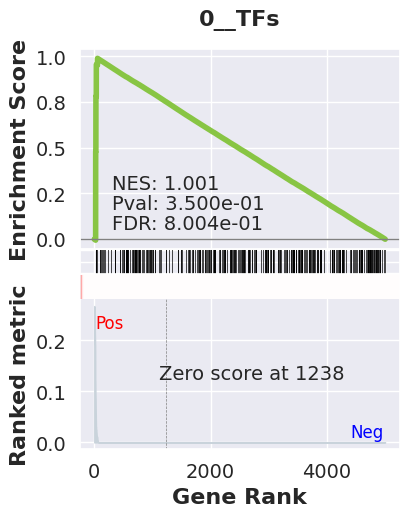

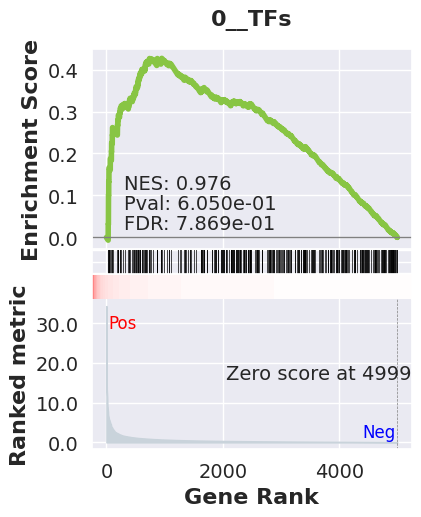

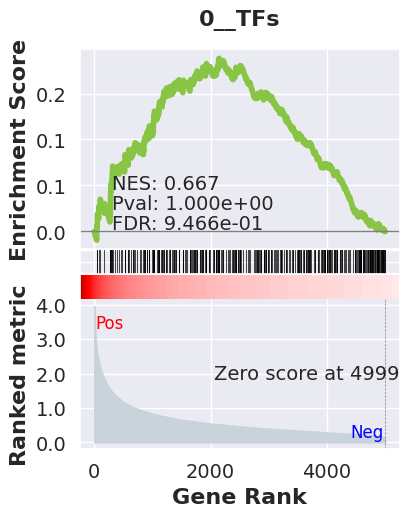

_________________________________________
TF specific enrichment


found some significant results for  17.647058823529413 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3565 genes
intersection pct: 0.713
precision:  0.0010623619711281117 
recall:  0.9992590397154713 
random precision: 0.001062203773751226



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  2%|█▌                                                                | 3/128 [00:00<00:05, 22.82it/s]


  5%|███▌                                                              | 7/128 [00:00<00:04, 27.87it/s]


  9%|█████▌                                                           | 11/128 [00:00<00:04, 28.86it/s]


 12%|███████▌                                                         | 15/128 [00:00<00:03, 29.55it/s]


 14%|█████████▏                                                       | 18/128 [00:00<00:03, 29.15it/s]


 16%|██████████▋                                                      | 21/128 [00:00<00:03, 29.18it/s]


 19%|████████████▏                                                    | 24/128 [00:00<00:03, 28.66it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:03, 28.48it/s]


 23%|███████████████▏                                                 | 30/128 [00:01<00:03, 28.52it/s]


 26%|████████████████▊                                                | 33/128 [00:01<00:03, 28.11it/s]


 28%|██████████████████▎                                              | 36/128 [00:01<00:03, 28.43it/s]


 30%|███████████████████▊                                             | 39/128 [00:01<00:03, 28.04it/s]


 33%|█████████████████████▎                                           | 42/128 [00:01<00:03, 28.22it/s]


 35%|██████████████████████▊                                          | 45/128 [00:01<00:02, 27.92it/s]


 38%|████████████████████████▍                                        | 48/128 [00:01<00:02, 28.29it/s]


 40%|█████████████████████████▉                                       | 51/128 [00:01<00:02, 28.43it/s]


 42%|███████████████████████████▍                                     | 54/128 [00:01<00:02, 28.01it/s]


 45%|████████████████████████████▉                                    | 57/128 [00:02<00:02, 28.35it/s]


 48%|██████████████████████████████▉                                  | 61/128 [00:02<00:02, 30.90it/s]


 52%|██████████████████████████████████                               | 67/128 [00:02<00:01, 37.80it/s]


 56%|████████████████████████████████████▌                            | 72/128 [00:02<00:01, 40.38it/s]


 60%|███████████████████████████████████████                          | 77/128 [00:02<00:01, 42.71it/s]


 64%|█████████████████████████████████████████▋                       | 82/128 [00:02<00:01, 42.41it/s]


 68%|████████████████████████████████████████████▏                    | 87/128 [00:02<00:00, 44.09it/s]


 73%|███████████████████████████████████████████████▏                 | 93/128 [00:02<00:00, 46.69it/s]


 77%|█████████████████████████████████████████████████▊               | 98/128 [00:02<00:00, 45.99it/s]


 81%|████████████████████████████████████████████████████            | 104/128 [00:03<00:00, 48.20it/s]


 85%|██████████████████████████████████████████████████████▌         | 109/128 [00:03<00:00, 47.36it/s]


 90%|█████████████████████████████████████████████████████████▌      | 115/128 [00:03<00:00, 48.90it/s]


 94%|████████████████████████████████████████████████████████████    | 120/128 [00:03<00:00, 48.81it/s]


 98%|██████████████████████████████████████████████████████████████▌ | 125/128 [00:03<00:00, 48.70it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 36.57it/s]

Average Precision (AP):  0.0012211835133077254
Area Under Precision-Recall Curve (AUPRC):  0.0012203552961740885
EPR: 1.3262989466872428


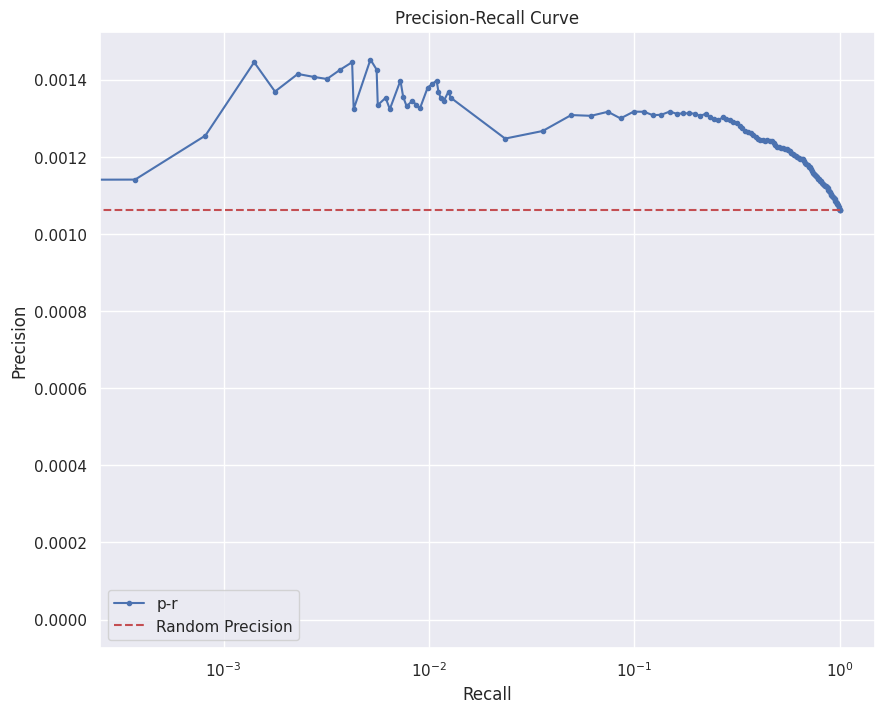

base enrichment


Top central genes: []


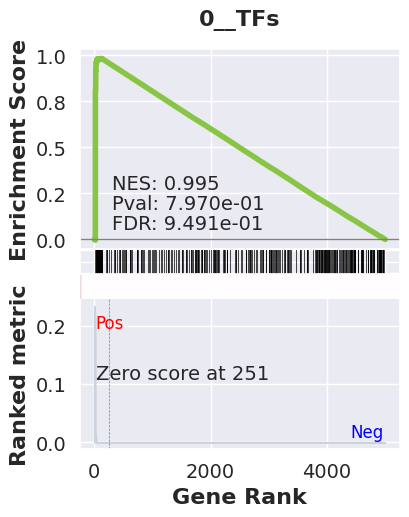

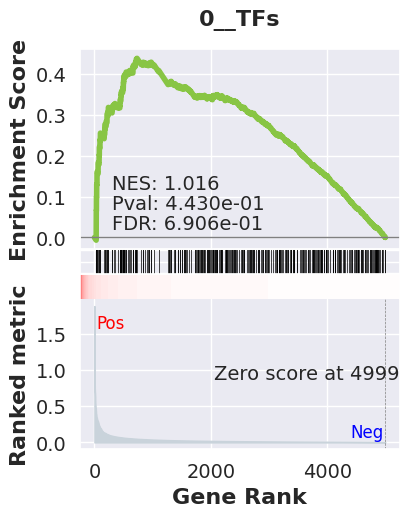

_________________________________________
TF specific enrichment


found some significant results for  11.764705882352942 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3565 genes
intersection pct: 0.713
precision:  0.004540668795146984 
recall:  0.33521043272080614 
random precision: 0.001062203773751226



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 42.63it/s]


  9%|█████▌                                                           | 11/128 [00:00<00:02, 48.63it/s]


 12%|████████▏                                                        | 16/128 [00:00<00:02, 47.38it/s]


 17%|███████████▏                                                     | 22/128 [00:00<00:02, 49.04it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:02, 49.34it/s]


 25%|████████████████▎                                                | 32/128 [00:00<00:02, 47.96it/s]


 29%|██████████████████▊                                              | 37/128 [00:00<00:01, 45.61it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 46.19it/s]


 38%|████████████████████████▍                                        | 48/128 [00:01<00:01, 48.21it/s]


 41%|██████████████████████████▉                                      | 53/128 [00:01<00:01, 47.11it/s]


 46%|█████████████████████████████▉                                   | 59/128 [00:01<00:01, 48.59it/s]


 50%|████████████████████████████████▌                                | 64/128 [00:01<00:01, 47.66it/s]


 55%|███████████████████████████████████▌                             | 70/128 [00:01<00:01, 49.01it/s]


 59%|██████████████████████████████████████                           | 75/128 [00:01<00:01, 49.08it/s]


 62%|████████████████████████████████████████▋                        | 80/128 [00:01<00:00, 48.72it/s]


 66%|███████████████████████████████████████████▏                     | 85/128 [00:01<00:00, 48.20it/s]


 71%|██████████████████████████████████████████████▏                  | 91/128 [00:01<00:00, 48.99it/s]


 76%|█████████████████████████████████████████████████▎               | 97/128 [00:02<00:00, 50.24it/s]


 80%|███████████████████████████████████████████████████▌            | 103/128 [00:02<00:00, 48.58it/s]


 85%|██████████████████████████████████████████████████████▌         | 109/128 [00:02<00:00, 50.02it/s]


 90%|█████████████████████████████████████████████████████████▌      | 115/128 [00:02<00:00, 48.48it/s]


 95%|████████████████████████████████████████████████████████████▌   | 121/128 [00:02<00:00, 49.90it/s]


 99%|███████████████████████████████████████████████████████████████▌| 127/128 [00:02<00:00, 48.68it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 48.41it/s]

Average Precision (AP):  0.003407806792340575
Area Under Precision-Recall Curve (AUPRC):  0.0028462503625924654
EPR: 8.287359747942153


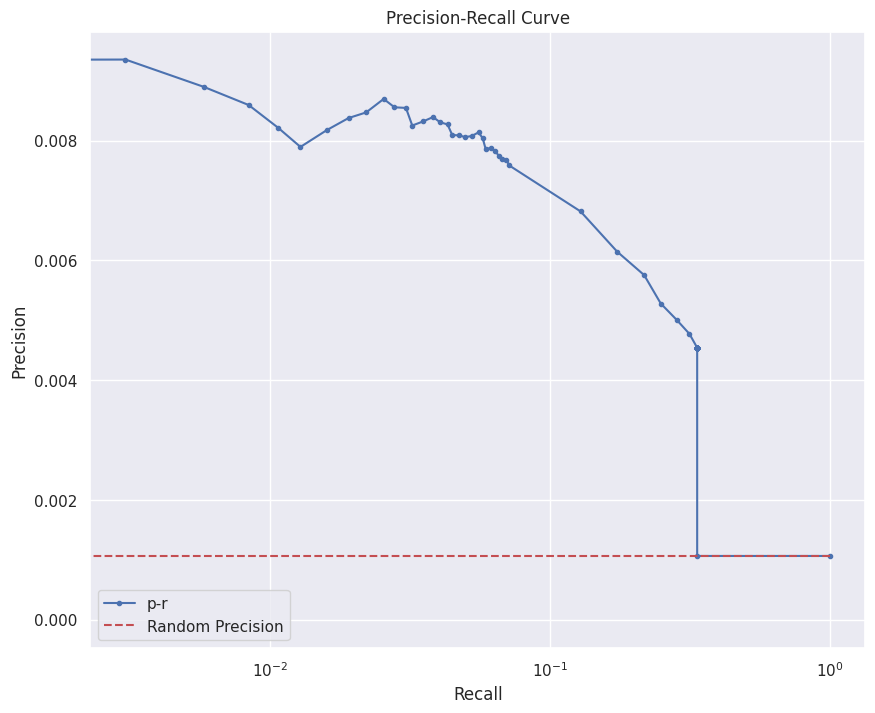

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/61 [00:00<?, ?it/s]

kidney loop of Henle thick ascending limb epithelial cell (243, 5000)
base enrichment


Top central genes: []


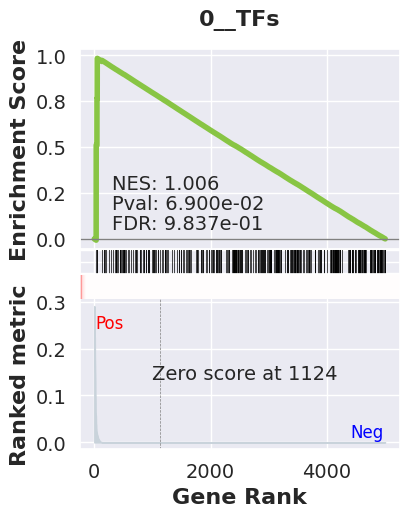

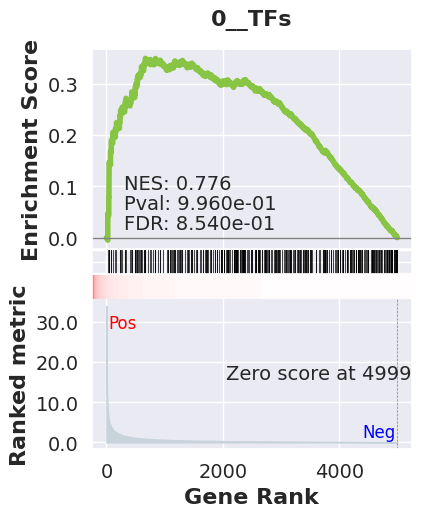

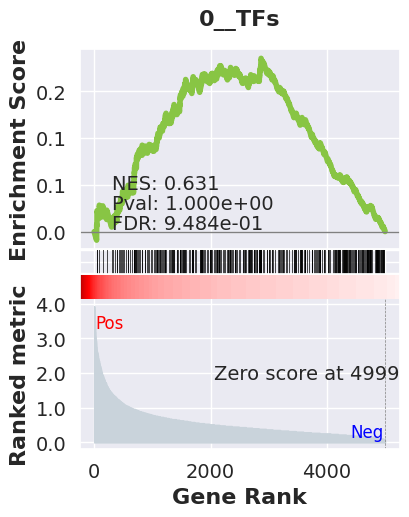

_________________________________________
TF specific enrichment


found some significant results for  7.5 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3514 genes
intersection pct: 0.7028
precision:  0.0012412273020088827 
recall:  0.9638441489006215 
random precision: 0.0012121008868434197



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 41.28it/s]


  8%|█████                                                            | 10/128 [00:00<00:02, 40.57it/s]


 12%|███████▌                                                         | 15/128 [00:00<00:02, 39.45it/s]


 15%|█████████▋                                                       | 19/128 [00:00<00:03, 35.82it/s]


 18%|███████████▋                                                     | 23/128 [00:00<00:03, 32.00it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:03, 32.01it/s]


 24%|███████████████▋                                                 | 31/128 [00:00<00:03, 31.37it/s]


 28%|██████████████████▎                                              | 36/128 [00:01<00:02, 35.26it/s]


 31%|████████████████████▎                                            | 40/128 [00:01<00:02, 33.64it/s]


 34%|██████████████████████▎                                          | 44/128 [00:01<00:02, 32.36it/s]


 38%|████████████████████████▍                                        | 48/128 [00:01<00:02, 32.48it/s]


 41%|██████████████████████████▉                                      | 53/128 [00:01<00:02, 34.51it/s]


 45%|████████████████████████████▉                                    | 57/128 [00:01<00:02, 34.89it/s]


 48%|██████████████████████████████▉                                  | 61/128 [00:01<00:01, 35.08it/s]


 51%|█████████████████████████████████                                | 65/128 [00:01<00:01, 35.04it/s]


 54%|███████████████████████████████████                              | 69/128 [00:01<00:01, 35.50it/s]


 57%|█████████████████████████████████████                            | 73/128 [00:02<00:01, 36.13it/s]


 60%|███████████████████████████████████████                          | 77/128 [00:02<00:01, 36.05it/s]


 64%|█████████████████████████████████████████▋                       | 82/128 [00:02<00:01, 37.83it/s]


 67%|███████████████████████████████████████████▋                     | 86/128 [00:02<00:01, 36.81it/s]


 70%|█████████████████████████████████████████████▋                   | 90/128 [00:02<00:01, 37.43it/s]


 73%|███████████████████████████████████████████████▋                 | 94/128 [00:02<00:00, 37.08it/s]


 77%|██████████████████████████████████████████████████▎              | 99/128 [00:02<00:00, 38.41it/s]


 80%|███████████████████████████████████████████████████▌            | 103/128 [00:02<00:00, 37.98it/s]


 84%|█████████████████████████████████████████████████████▌          | 107/128 [00:02<00:00, 37.62it/s]


 88%|████████████████████████████████████████████████████████        | 112/128 [00:03<00:00, 38.51it/s]


 91%|██████████████████████████████████████████████████████████      | 116/128 [00:03<00:00, 38.19it/s]


 95%|████████████████████████████████████████████████████████████▌   | 121/128 [00:03<00:00, 39.78it/s]


 98%|██████████████████████████████████████████████████████████████▌ | 125/128 [00:03<00:00, 39.04it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 36.28it/s]

Average Precision (AP):  0.0013279023374561637
Area Under Precision-Recall Curve (AUPRC):  0.001327038658172769
EPR: 1.0477227267666527


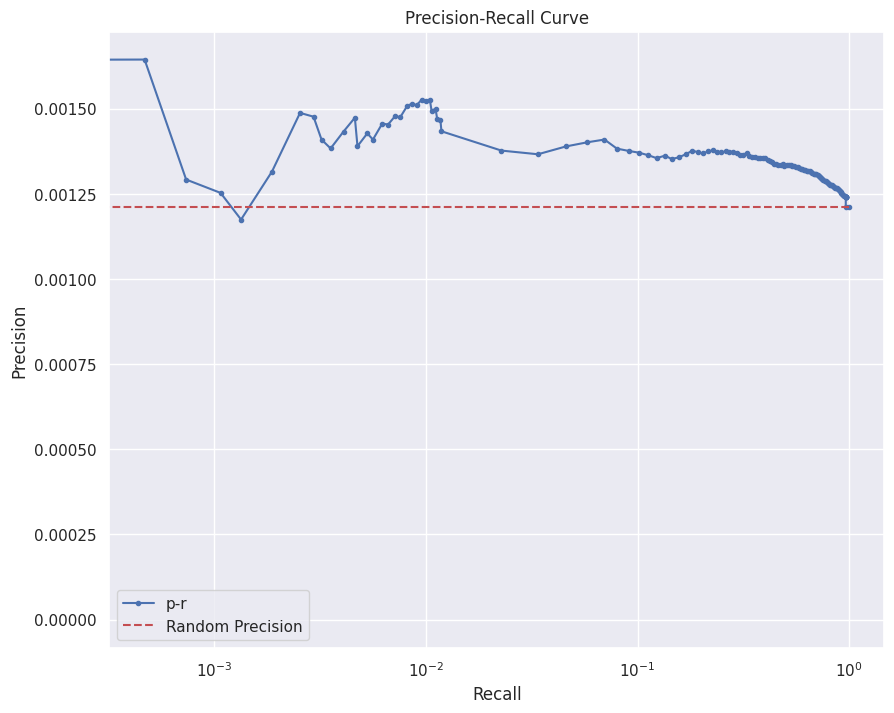

base enrichment


Top central genes: []


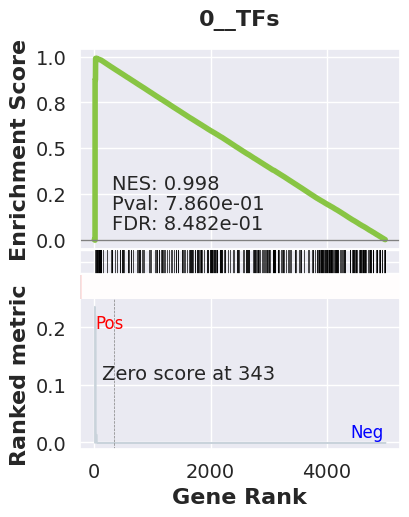

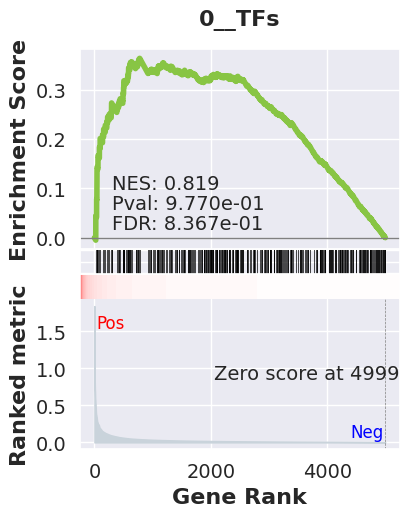

_________________________________________
TF specific enrichment


found some significant results for  2.5 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3514 genes
intersection pct: 0.7028
precision:  0.006305103022984771 
recall:  0.41108066564191675 
random precision: 0.0012121008868434197



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 49.24it/s]


  8%|█████                                                            | 10/128 [00:00<00:02, 45.06it/s]


 12%|████████▏                                                        | 16/128 [00:00<00:02, 47.78it/s]


 16%|██████████▋                                                      | 21/128 [00:00<00:02, 48.02it/s]


 20%|█████████████▏                                                   | 26/128 [00:00<00:02, 45.47it/s]


 24%|███████████████▋                                                 | 31/128 [00:00<00:02, 46.45it/s]


 28%|██████████████████▎                                              | 36/128 [00:00<00:02, 44.83it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 47.31it/s]


 37%|███████████████████████▊                                         | 47/128 [00:01<00:01, 46.14it/s]


 41%|██████████████████████████▍                                      | 52/128 [00:01<00:01, 45.15it/s]


 45%|████████████████████████████▉                                    | 57/128 [00:01<00:01, 45.76it/s]


 49%|███████████████████████████████▉                                 | 63/128 [00:01<00:01, 48.49it/s]


 53%|██████████████████████████████████▌                              | 68/128 [00:01<00:01, 47.79it/s]


 57%|█████████████████████████████████████                            | 73/128 [00:01<00:01, 47.41it/s]


 62%|████████████████████████████████████████                         | 79/128 [00:01<00:01, 48.64it/s]


 66%|██████████████████████████████████████████▋                      | 84/128 [00:01<00:00, 47.56it/s]


 70%|█████████████████████████████████████████████▋                   | 90/128 [00:01<00:00, 49.10it/s]


 74%|████████████████████████████████████████████████▏                | 95/128 [00:02<00:00, 47.78it/s]


 78%|██████████████████████████████████████████████████              | 100/128 [00:02<00:00, 47.26it/s]


 82%|████████████████████████████████████████████████████▌           | 105/128 [00:02<00:00, 47.54it/s]


 87%|███████████████████████████████████████████████████████▌        | 111/128 [00:02<00:00, 49.53it/s]


 91%|██████████████████████████████████████████████████████████▌     | 117/128 [00:02<00:00, 49.32it/s]


 95%|█████████████████████████████████████████████████████████████   | 122/128 [00:02<00:00, 49.50it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 49.94it/s]


100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 47.77it/s]

Average Precision (AP):  0.004505855980447217
Area Under Precision-Recall Curve (AUPRC):  0.003860584701241157
EPR: 8.418530983135287


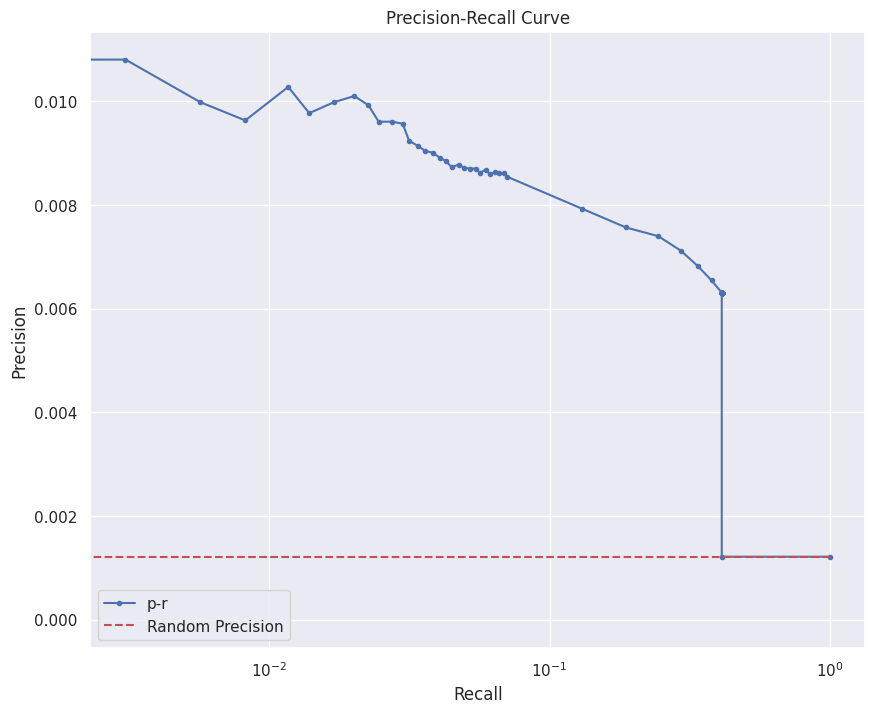

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/83 [00:00<?, ?it/s]

kidney collecting duct principal cell (332, 5000)
base enrichment


Top central genes: []


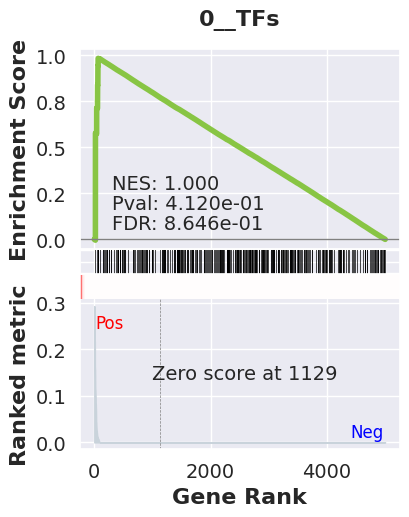

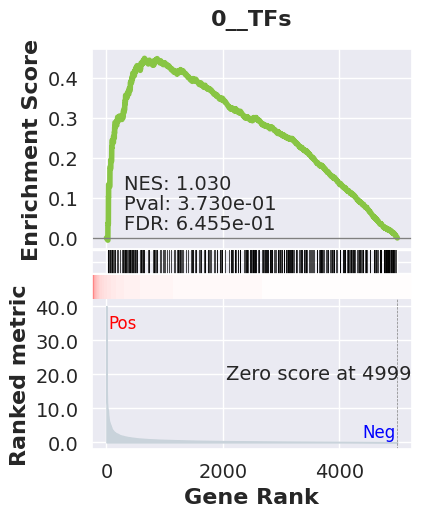

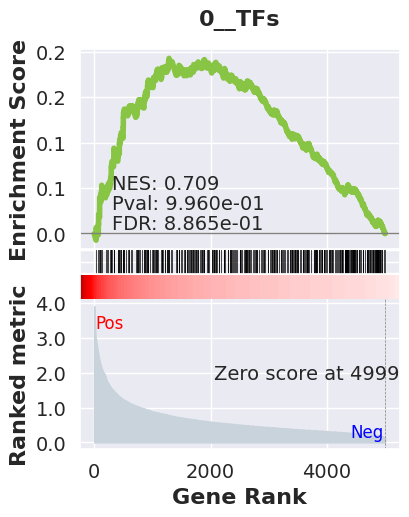

_________________________________________
TF specific enrichment


found some significant results for  15.714285714285714 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3594 genes
intersection pct: 0.7188
precision:  0.001370072406037335 
recall:  0.9953374651731393 
random precision: 0.0013619352909207464



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 43.31it/s]


  9%|█████▌                                                           | 11/128 [00:00<00:02, 48.32it/s]


 12%|████████▏                                                        | 16/128 [00:00<00:02, 45.97it/s]


 17%|███████████▏                                                     | 22/128 [00:00<00:02, 48.46it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:02, 47.39it/s]


 25%|████████████████▎                                                | 32/128 [00:00<00:02, 47.33it/s]


 29%|██████████████████▊                                              | 37/128 [00:00<00:01, 46.34it/s]


 34%|█████████████████████▊                                           | 43/128 [00:00<00:01, 48.27it/s]


 38%|████████████████████████▉                                        | 49/128 [00:01<00:01, 48.26it/s]


 42%|███████████████████████████▍                                     | 54/128 [00:01<00:01, 47.49it/s]


 47%|██████████████████████████████▍                                  | 60/128 [00:01<00:01, 48.14it/s]


 51%|█████████████████████████████████                                | 65/128 [00:01<00:01, 47.34it/s]


 55%|████████████████████████████████████                             | 71/128 [00:01<00:01, 48.82it/s]


 59%|██████████████████████████████████████▌                          | 76/128 [00:01<00:01, 47.10it/s]


 63%|█████████████████████████████████████████▏                       | 81/128 [00:01<00:00, 47.64it/s]


 67%|███████████████████████████████████████████▋                     | 86/128 [00:01<00:00, 46.94it/s]


 72%|██████████████████████████████████████████████▋                  | 92/128 [00:01<00:00, 48.63it/s]


 76%|█████████████████████████████████████████████████▎               | 97/128 [00:02<00:00, 48.18it/s]


 80%|███████████████████████████████████████████████████             | 102/128 [00:02<00:00, 47.90it/s]


 84%|██████████████████████████████████████████████████████          | 108/128 [00:02<00:00, 48.39it/s]


 88%|████████████████████████████████████████████████████████▌       | 113/128 [00:02<00:00, 47.23it/s]


 93%|███████████████████████████████████████████████████████████▌    | 119/128 [00:02<00:00, 48.73it/s]


 97%|██████████████████████████████████████████████████████████████  | 124/128 [00:02<00:00, 47.21it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 47.67it/s]

Average Precision (AP):  0.0017540832164377762
Area Under Precision-Recall Curve (AUPRC):  0.0017526037445657117
EPR: 2.1358046925209537


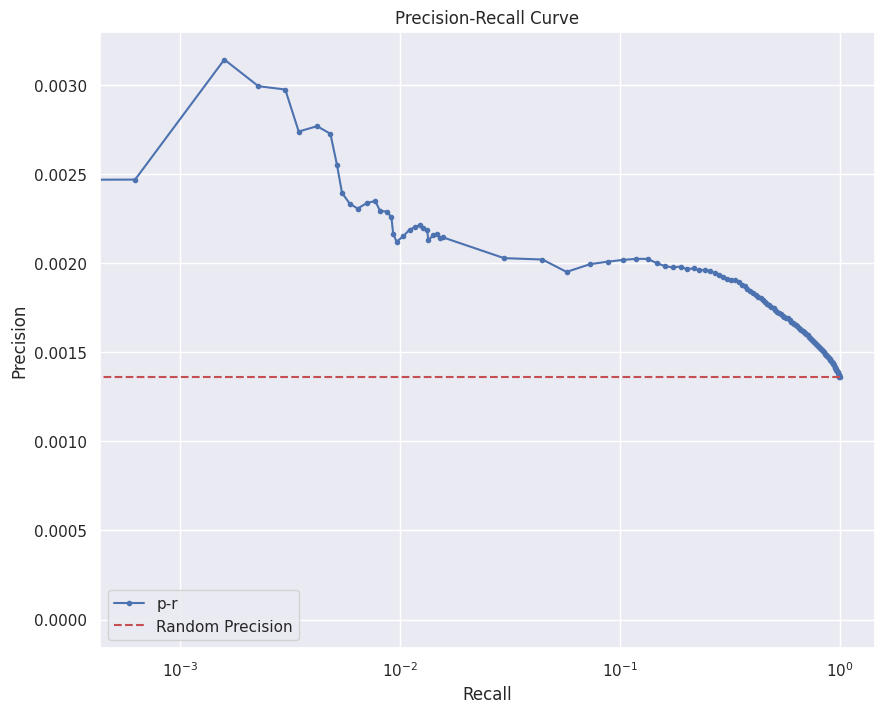

base enrichment


Top central genes: []


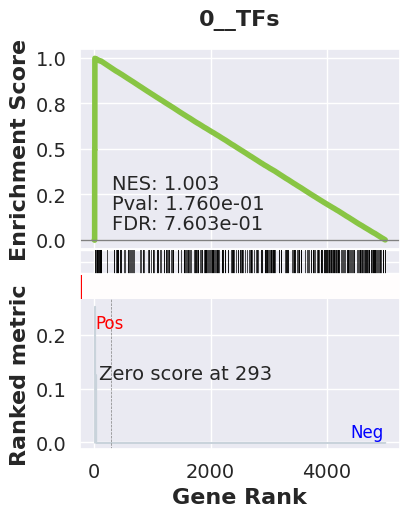

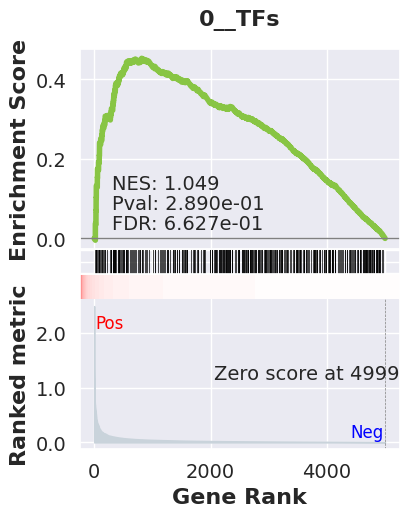

_________________________________________
TF specific enrichment


found some significant results for  5.714285714285714 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3594 genes
intersection pct: 0.7188
precision:  0.007047180629937937 
recall:  0.4427133678285097 
random precision: 0.0013619352909207464



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 48.23it/s]


  8%|█████                                                            | 10/128 [00:00<00:02, 46.78it/s]


 12%|████████▏                                                        | 16/128 [00:00<00:02, 48.99it/s]


 16%|██████████▋                                                      | 21/128 [00:00<00:02, 47.39it/s]


 20%|█████████████▏                                                   | 26/128 [00:00<00:02, 47.56it/s]


 24%|███████████████▋                                                 | 31/128 [00:00<00:02, 47.29it/s]


 29%|██████████████████▊                                              | 37/128 [00:00<00:01, 49.03it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 48.01it/s]


 37%|███████████████████████▊                                         | 47/128 [00:00<00:01, 48.28it/s]


 41%|██████████████████████████▉                                      | 53/128 [00:01<00:01, 48.71it/s]


 45%|█████████████████████████████▍                                   | 58/128 [00:01<00:01, 47.91it/s]


 50%|████████████████████████████████▌                                | 64/128 [00:01<00:01, 48.96it/s]


 54%|███████████████████████████████████                              | 69/128 [00:01<00:01, 47.71it/s]


 58%|█████████████████████████████████████▌                           | 74/128 [00:01<00:01, 47.70it/s]


 62%|████████████████████████████████████████                         | 79/128 [00:01<00:01, 46.63it/s]


 66%|███████████████████████████████████████████▏                     | 85/128 [00:01<00:00, 48.27it/s]


 70%|█████████████████████████████████████████████▋                   | 90/128 [00:01<00:00, 46.90it/s]


 74%|████████████████████████████████████████████████▏                | 95/128 [00:01<00:00, 47.51it/s]


 78%|██████████████████████████████████████████████████              | 100/128 [00:02<00:00, 47.93it/s]


 82%|████████████████████████████████████████████████████▌           | 105/128 [00:02<00:00, 47.18it/s]


 87%|███████████████████████████████████████████████████████▌        | 111/128 [00:02<00:00, 48.44it/s]


 91%|██████████████████████████████████████████████████████████      | 116/128 [00:02<00:00, 47.28it/s]


 95%|████████████████████████████████████████████████████████████▌   | 121/128 [00:02<00:00, 47.70it/s]


 98%|███████████████████████████████████████████████████████████████ | 126/128 [00:02<00:00, 47.08it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 47.77it/s]

Average Precision (AP):  0.0064695607089728276
Area Under Precision-Recall Curve (AUPRC):  0.005742839350667983
EPR: 11.772423009758835


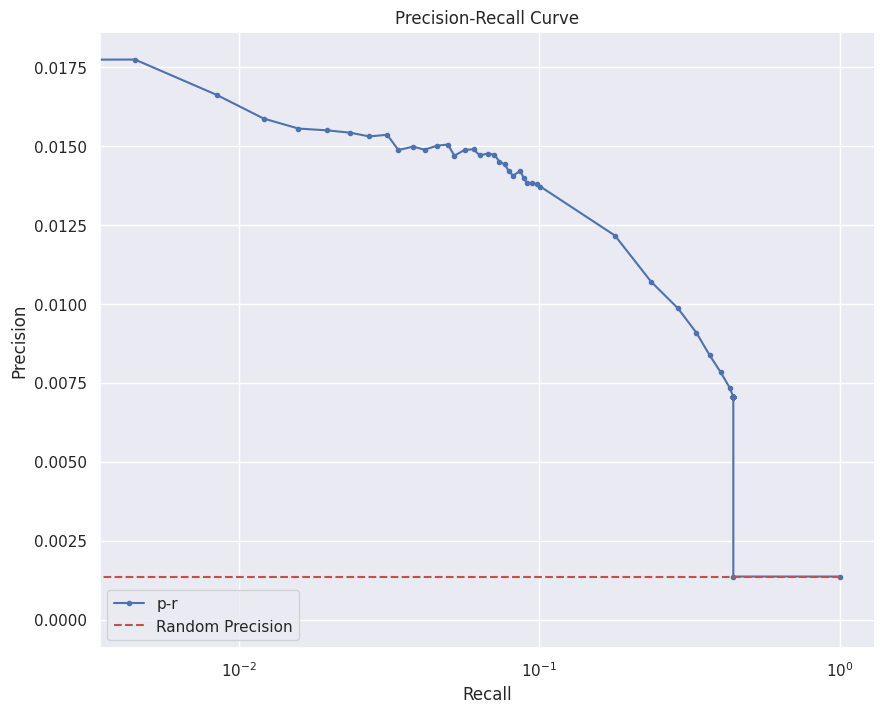

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
num_proc must be <= 7. Reducing num_proc to 7 for dataset of size 7.


[d3graph] WARNING> num_proc must be <= 7. Reducing num_proc to 7 for dataset of size 7.


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/2 [00:00<?, ?it/s]

mesangial cell (7, 4802)
base enrichment


Top central genes: []


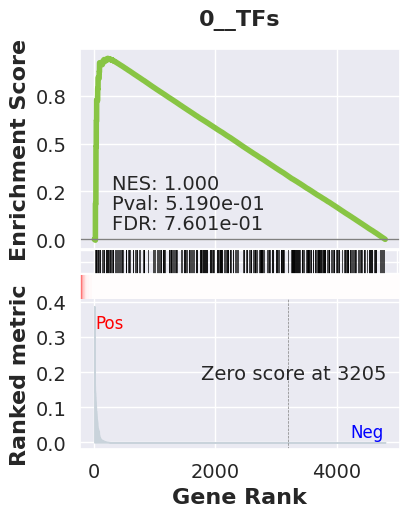

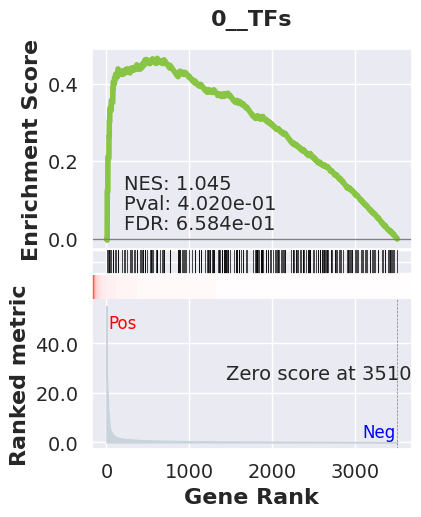

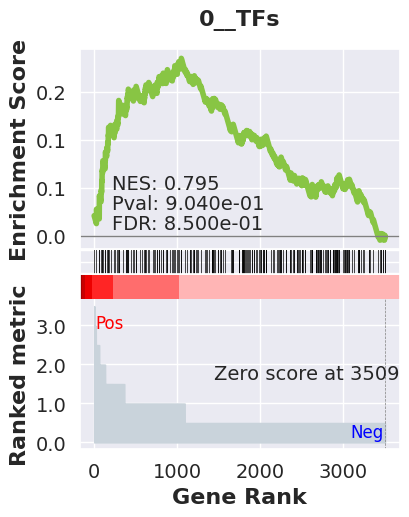

_________________________________________
TF specific enrichment


found some significant results for  9.090909090909092 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3170 genes
intersection pct: 0.6601416076634735
precision:  0.0016249885447755202 
recall:  0.3218562874251497 
random precision: 0.0010639346269509533



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  5%|███                                                               | 6/128 [00:00<00:02, 56.33it/s]


 10%|██████▌                                                          | 13/128 [00:00<00:01, 61.68it/s]


 16%|██████████▏                                                      | 20/128 [00:00<00:01, 63.61it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:01, 59.66it/s]


 27%|█████████████████▎                                               | 34/128 [00:00<00:01, 60.23it/s]


 32%|████████████████████▊                                            | 41/128 [00:00<00:01, 57.73it/s]


 38%|████████████████████████▍                                        | 48/128 [00:00<00:01, 59.70it/s]


 43%|███████████████████████████▉                                     | 55/128 [00:00<00:01, 58.73it/s]


 48%|███████████████████████████████▍                                 | 62/128 [00:01<00:01, 59.60it/s]


 53%|██████████████████████████████████▌                              | 68/128 [00:01<00:01, 58.63it/s]


 59%|██████████████████████████████████████                           | 75/128 [00:01<00:00, 59.71it/s]


 63%|█████████████████████████████████████████▏                       | 81/128 [00:01<00:00, 59.47it/s]


 68%|████████████████████████████████████████████▏                    | 87/128 [00:01<00:00, 58.86it/s]


 73%|███████████████████████████████████████████████▋                 | 94/128 [00:01<00:00, 60.85it/s]


 79%|██████████████████████████████████████████████████▌             | 101/128 [00:01<00:00, 59.35it/s]


 84%|██████████████████████████████████████████████████████          | 108/128 [00:01<00:00, 61.14it/s]


 90%|█████████████████████████████████████████████████████████▌      | 115/128 [00:01<00:00, 59.89it/s]


 95%|█████████████████████████████████████████████████████████████   | 122/128 [00:02<00:00, 60.13it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 59.53it/s]

Average Precision (AP):  0.0014995137243832874
Area Under Precision-Recall Curve (AUPRC):  0.001386025707952281
EPR: 2.204137422895596


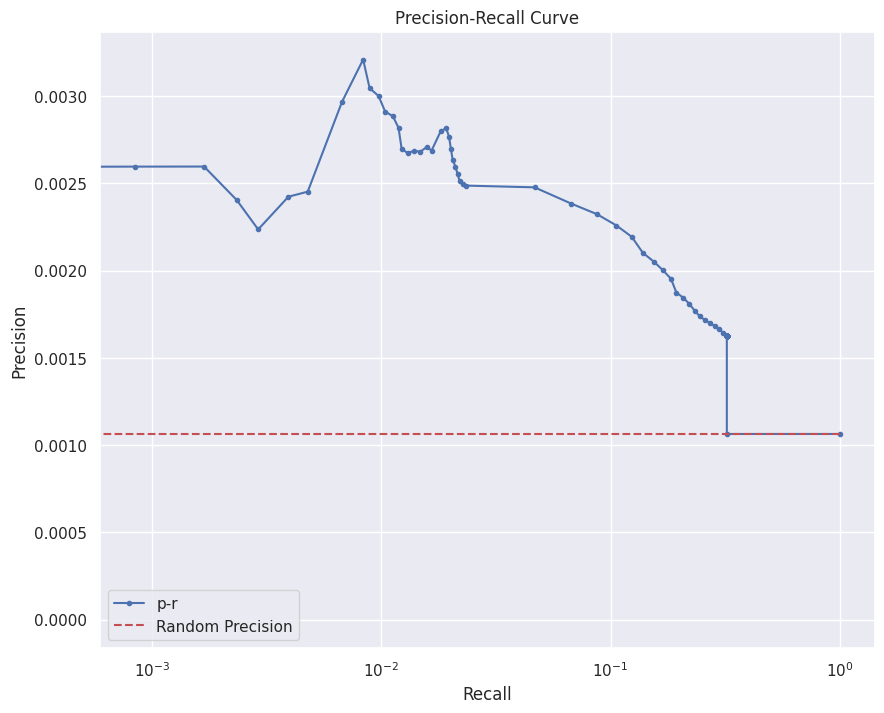

base enrichment


Top central genes: []


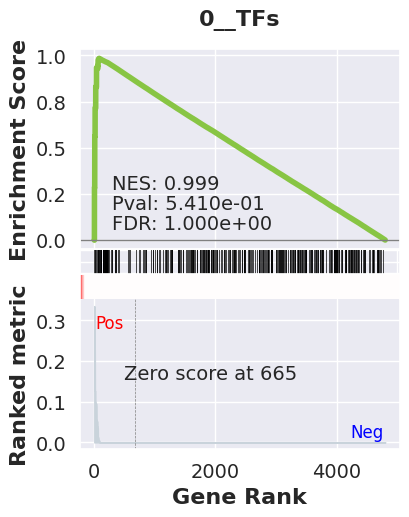

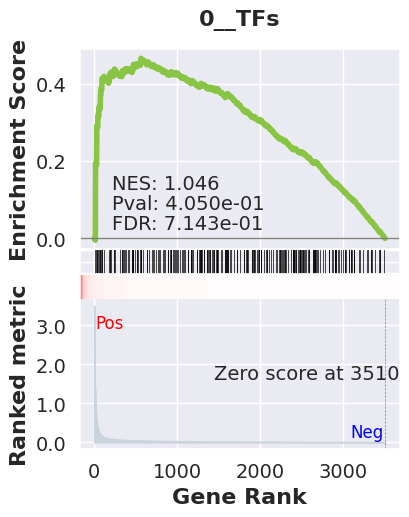

_________________________________________
TF specific enrichment


found some significant results for  2.272727272727273 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3170 genes
intersection pct: 0.6601416076634735
precision:  0.01150364332097868 
recall:  0.17917290419161677 
random precision: 0.0010639346269509533



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  5%|███▌                                                              | 7/128 [00:00<00:01, 63.41it/s]


 11%|███████                                                          | 14/128 [00:00<00:01, 60.51it/s]


 16%|██████████▋                                                      | 21/128 [00:00<00:01, 59.31it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:01, 58.71it/s]


 26%|████████████████▊                                                | 33/128 [00:00<00:01, 57.63it/s]


 31%|████████████████████▎                                            | 40/128 [00:00<00:01, 59.18it/s]


 36%|███████████████████████▎                                         | 46/128 [00:00<00:01, 57.58it/s]


 41%|██████████████████████████▉                                      | 53/128 [00:00<00:01, 58.80it/s]


 46%|█████████████████████████████▉                                   | 59/128 [00:01<00:01, 58.35it/s]


 52%|█████████████████████████████████▌                               | 66/128 [00:01<00:01, 60.19it/s]


 57%|█████████████████████████████████████                            | 73/128 [00:01<00:00, 59.32it/s]


 62%|████████████████████████████████████████                         | 79/128 [00:01<00:00, 59.41it/s]


 66%|███████████████████████████████████████████▏                     | 85/128 [00:01<00:00, 59.25it/s]


 71%|██████████████████████████████████████████████▏                  | 91/128 [00:01<00:00, 56.39it/s]


 77%|█████████████████████████████████████████████████▊               | 98/128 [00:01<00:00, 58.16it/s]


 81%|████████████████████████████████████████████████████            | 104/128 [00:01<00:00, 56.59it/s]


 86%|███████████████████████████████████████████████████████         | 110/128 [00:01<00:00, 57.43it/s]


 91%|██████████████████████████████████████████████████████████      | 116/128 [00:01<00:00, 57.05it/s]


 96%|█████████████████████████████████████████████████████████████▌  | 123/128 [00:02<00:00, 59.34it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 58.83it/s]

Average Precision (AP):  0.0040380163957205875
Area Under Precision-Recall Curve (AUPRC):  0.0035213033674252915
EPR: 19.364686074579677


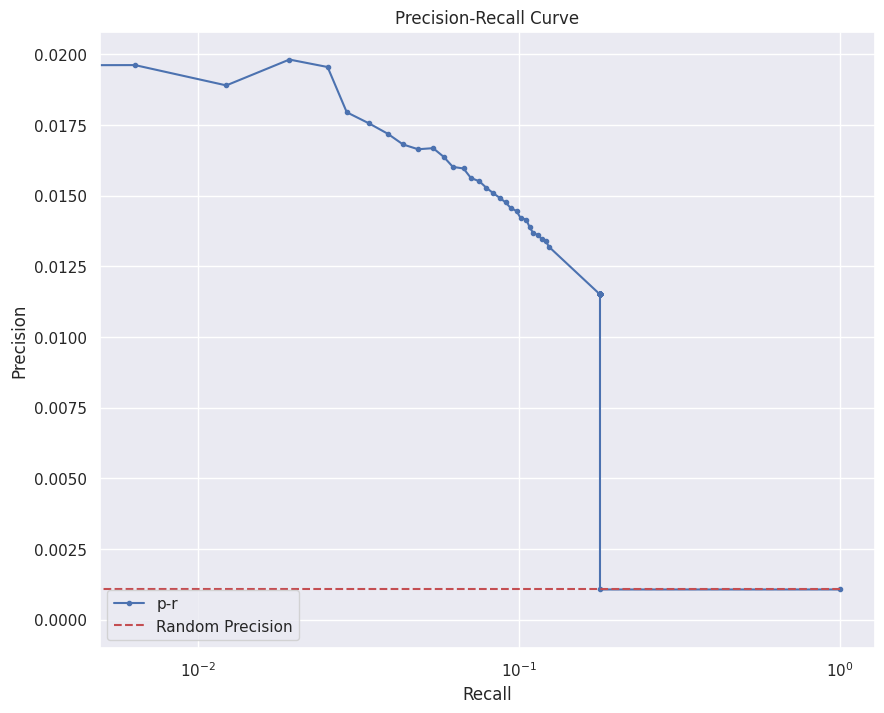

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/51 [00:00<?, ?it/s]

blood vessel smooth muscle cell (202, 5000)
base enrichment


Top central genes: []


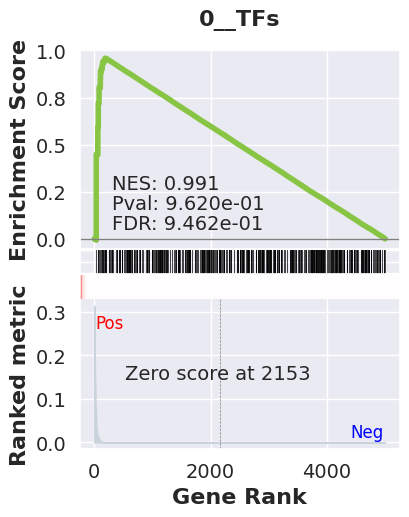

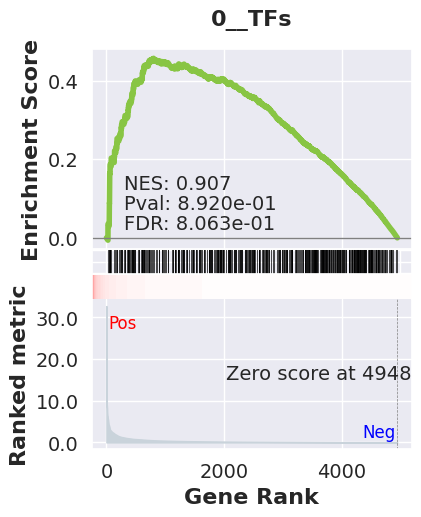

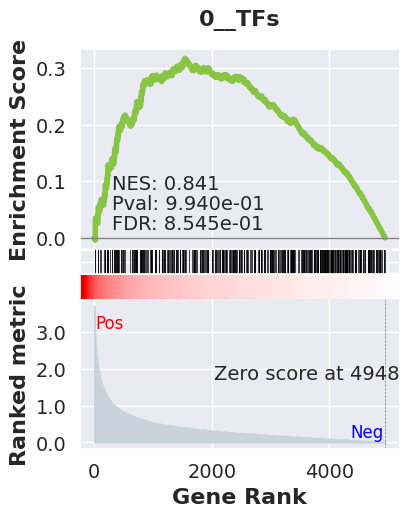

_________________________________________
TF specific enrichment


found some significant results for  26.785714285714285 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3625 genes
intersection pct: 0.725
precision:  0.001901083851801466 
recall:  0.7064420669246528 
random precision: 0.0016719951282636828



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 46.62it/s]


  8%|█████                                                            | 10/128 [00:00<00:02, 46.07it/s]


 12%|████████▏                                                        | 16/128 [00:00<00:02, 48.28it/s]


 16%|██████████▋                                                      | 21/128 [00:00<00:02, 46.66it/s]


 20%|█████████████▏                                                   | 26/128 [00:00<00:02, 46.98it/s]


 24%|███████████████▋                                                 | 31/128 [00:00<00:02, 47.27it/s]


 28%|██████████████████▎                                              | 36/128 [00:00<00:01, 46.29it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 47.82it/s]


 37%|███████████████████████▊                                         | 47/128 [00:01<00:01, 46.66it/s]


 41%|██████████████████████████▍                                      | 52/128 [00:01<00:01, 46.02it/s]


 45%|████████████████████████████▉                                    | 57/128 [00:01<00:01, 45.53it/s]


 48%|███████████████████████████████▍                                 | 62/128 [00:01<00:01, 44.51it/s]


 52%|██████████████████████████████████                               | 67/128 [00:01<00:01, 44.21it/s]


 56%|████████████████████████████████████▌                            | 72/128 [00:01<00:01, 45.28it/s]


 60%|███████████████████████████████████████                          | 77/128 [00:01<00:01, 46.07it/s]


 64%|█████████████████████████████████████████▋                       | 82/128 [00:01<00:01, 45.28it/s]


 69%|████████████████████████████████████████████▋                    | 88/128 [00:01<00:00, 46.75it/s]


 73%|███████████████████████████████████████████████▏                 | 93/128 [00:02<00:00, 45.97it/s]


 77%|█████████████████████████████████████████████████▊               | 98/128 [00:02<00:00, 46.07it/s]


 81%|████████████████████████████████████████████████████            | 104/128 [00:02<00:00, 47.39it/s]


 85%|██████████████████████████████████████████████████████▌         | 109/128 [00:02<00:00, 47.38it/s]


 89%|█████████████████████████████████████████████████████████       | 114/128 [00:02<00:00, 46.16it/s]


 93%|███████████████████████████████████████████████████████████▌    | 119/128 [00:02<00:00, 46.55it/s]


 97%|██████████████████████████████████████████████████████████████  | 124/128 [00:02<00:00, 45.28it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 46.15it/s]

Average Precision (AP):  0.0023155917958879177
Area Under Precision-Recall Curve (AUPRC):  0.002275598158130363
EPR: 2.793994425444647


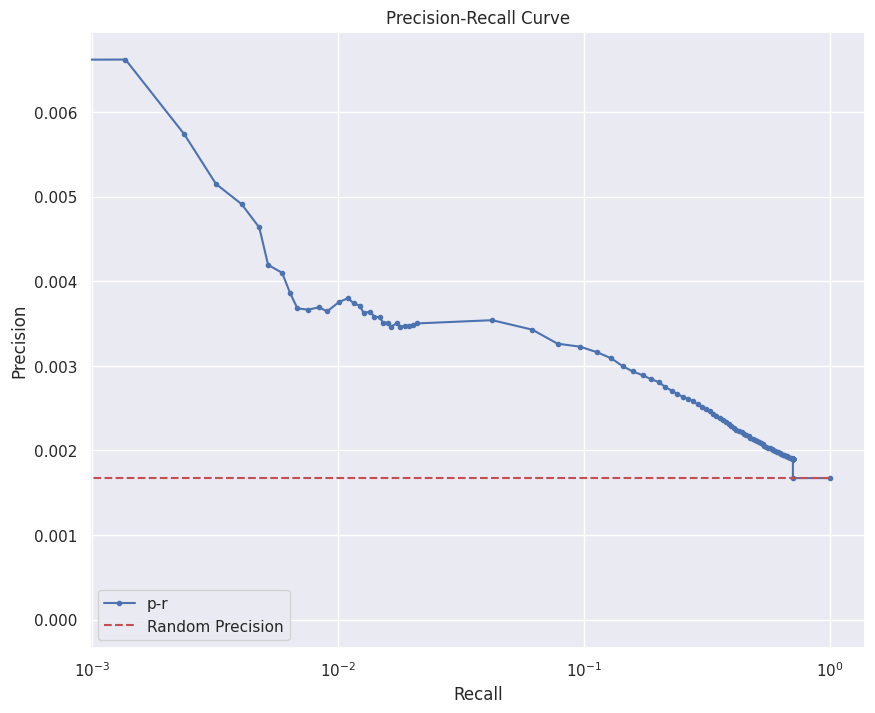

base enrichment


Top central genes: []


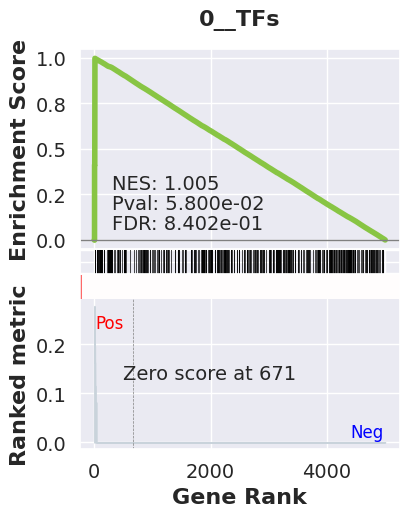

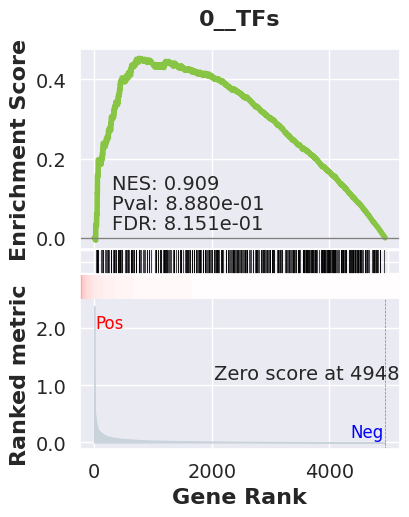

_________________________________________
TF specific enrichment


found some significant results for  8.928571428571429 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3625 genes
intersection pct: 0.725
precision:  0.009127600957537927 
recall:  0.34058729797404963 
random precision: 0.0016719951282636828



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  5%|███                                                               | 6/128 [00:00<00:02, 51.04it/s]


  9%|██████                                                           | 12/128 [00:00<00:02, 48.14it/s]


 13%|████████▋                                                        | 17/128 [00:00<00:02, 43.51it/s]


 17%|███████████▏                                                     | 22/128 [00:00<00:02, 40.00it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:02, 41.99it/s]


 25%|████████████████▎                                                | 32/128 [00:00<00:02, 44.05it/s]


 29%|██████████████████▊                                              | 37/128 [00:00<00:02, 44.28it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 44.27it/s]


 37%|███████████████████████▊                                         | 47/128 [00:01<00:01, 44.90it/s]


 41%|██████████████████████████▉                                      | 53/128 [00:01<00:01, 47.07it/s]


 45%|█████████████████████████████▍                                   | 58/128 [00:01<00:01, 45.61it/s]


 50%|████████████████████████████████▌                                | 64/128 [00:01<00:01, 47.25it/s]


 54%|███████████████████████████████████                              | 69/128 [00:01<00:01, 46.40it/s]


 58%|█████████████████████████████████████▌                           | 74/128 [00:01<00:01, 46.80it/s]


 62%|████████████████████████████████████████                         | 79/128 [00:01<00:01, 47.25it/s]


 66%|██████████████████████████████████████████▋                      | 84/128 [00:01<00:00, 46.26it/s]


 70%|█████████████████████████████████████████████▏                   | 89/128 [00:01<00:00, 45.82it/s]


 73%|███████████████████████████████████████████████▋                 | 94/128 [00:02<00:00, 46.14it/s]


 78%|██████████████████████████████████████████████████              | 100/128 [00:02<00:00, 47.83it/s]


 82%|████████████████████████████████████████████████████▌           | 105/128 [00:02<00:00, 46.02it/s]


 86%|███████████████████████████████████████████████████████         | 110/128 [00:02<00:00, 46.80it/s]


 90%|█████████████████████████████████████████████████████████▌      | 115/128 [00:02<00:00, 46.55it/s]


 94%|████████████████████████████████████████████████████████████    | 120/128 [00:02<00:00, 46.61it/s]


 98%|███████████████████████████████████████████████████████████████ | 126/128 [00:02<00:00, 47.33it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 45.83it/s]

Average Precision (AP):  0.006624245820167628
Area Under Precision-Recall Curve (AUPRC):  0.005691671754127069
EPR: 13.644958939190209


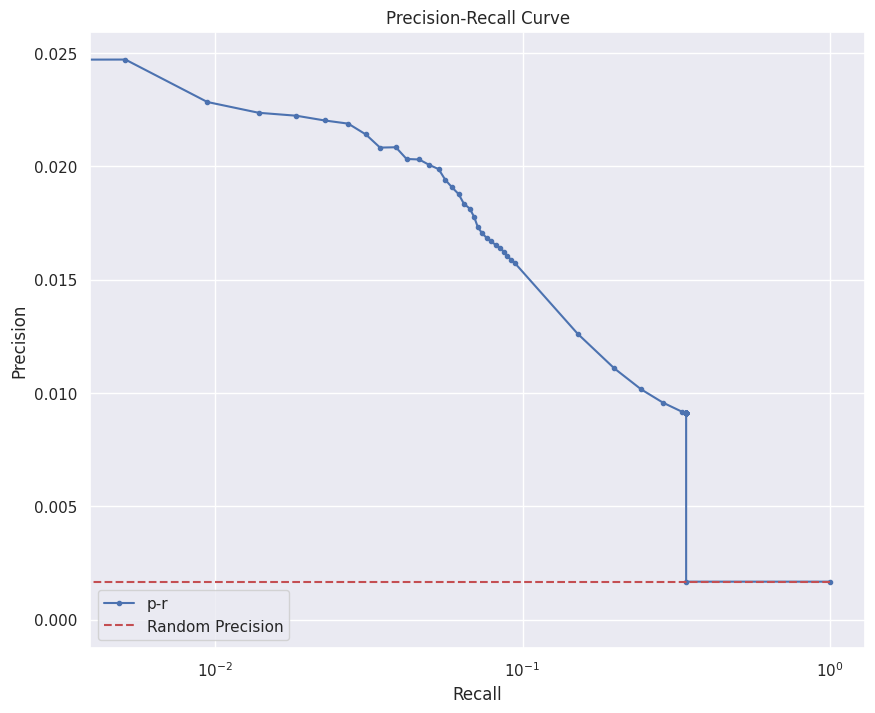

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/84 [00:00<?, ?it/s]

podocyte (334, 5000)
base enrichment


Top central genes: []


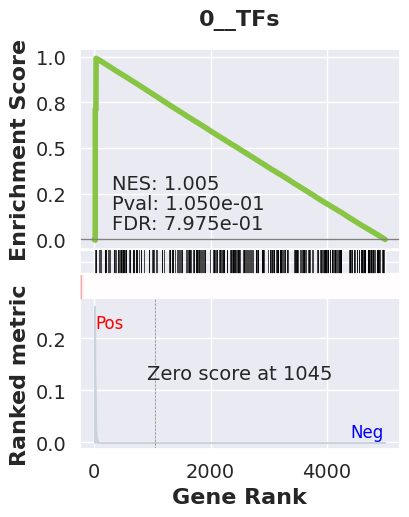

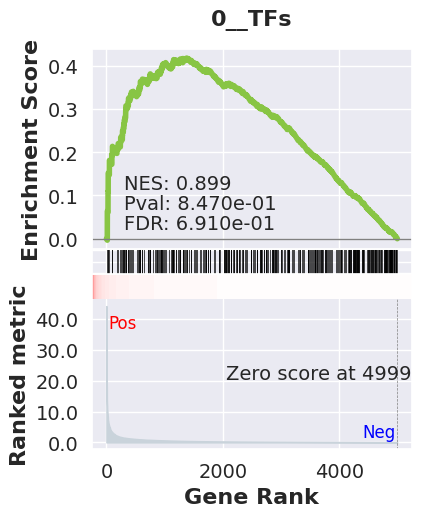

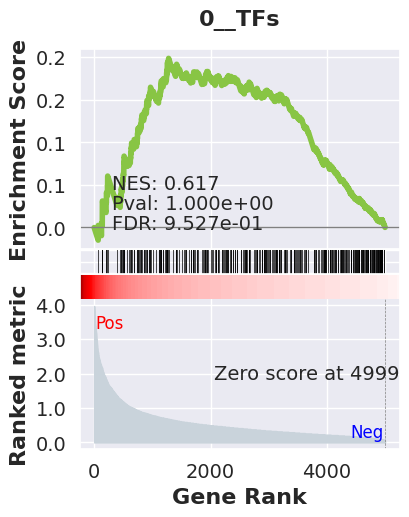

_________________________________________
TF specific enrichment


found some significant results for  4.25531914893617 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3603 genes
intersection pct: 0.7206
precision:  0.0015218365437682177 
recall:  0.940618179972593 
random precision: 0.001518183918238287



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 46.10it/s]


  8%|█████                                                            | 10/128 [00:00<00:02, 47.56it/s]


 12%|███████▌                                                         | 15/128 [00:00<00:02, 47.41it/s]


 16%|██████████▋                                                      | 21/128 [00:00<00:02, 48.66it/s]


 20%|█████████████▏                                                   | 26/128 [00:00<00:02, 47.17it/s]


 24%|███████████████▋                                                 | 31/128 [00:00<00:02, 47.44it/s]


 28%|██████████████████▎                                              | 36/128 [00:00<00:01, 46.22it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 47.75it/s]


 37%|███████████████████████▊                                         | 47/128 [00:00<00:01, 47.80it/s]


 41%|██████████████████████████▍                                      | 52/128 [00:01<00:01, 46.46it/s]


 45%|████████████████████████████▉                                    | 57/128 [00:01<00:01, 47.11it/s]


 48%|███████████████████████████████▍                                 | 62/128 [00:01<00:01, 45.37it/s]


 52%|██████████████████████████████████                               | 67/128 [00:01<00:01, 46.62it/s]


 56%|████████████████████████████████████▌                            | 72/128 [00:01<00:01, 47.05it/s]


 60%|███████████████████████████████████████                          | 77/128 [00:01<00:01, 47.70it/s]


 64%|█████████████████████████████████████████▋                       | 82/128 [00:01<00:00, 46.90it/s]


 68%|████████████████████████████████████████████▏                    | 87/128 [00:01<00:00, 45.41it/s]


 72%|██████████████████████████████████████████████▋                  | 92/128 [00:01<00:00, 46.36it/s]


 76%|█████████████████████████████████████████████████▎               | 97/128 [00:02<00:00, 46.05it/s]


 80%|███████████████████████████████████████████████████             | 102/128 [00:02<00:00, 46.06it/s]


 84%|█████████████████████████████████████████████████████▌          | 107/128 [00:02<00:00, 46.92it/s]


 88%|████████████████████████████████████████████████████████        | 112/128 [00:02<00:00, 45.26it/s]


 91%|██████████████████████████████████████████████████████████▌     | 117/128 [00:02<00:00, 46.55it/s]


 95%|█████████████████████████████████████████████████████████████   | 122/128 [00:02<00:00, 45.45it/s]


 99%|███████████████████████████████████████████████████████████████▌| 127/128 [00:02<00:00, 45.73it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 46.52it/s]

Average Precision (AP):  0.0017483598496949235
Area Under Precision-Recall Curve (AUPRC):  0.0017469349848108096
EPR: 2.688123089871557


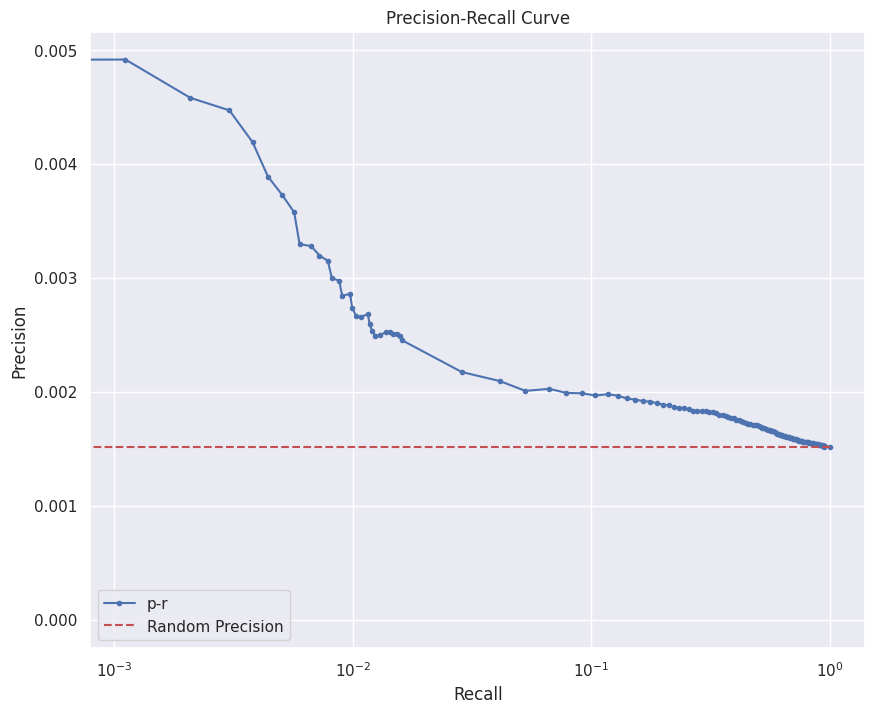

base enrichment


Top central genes: []


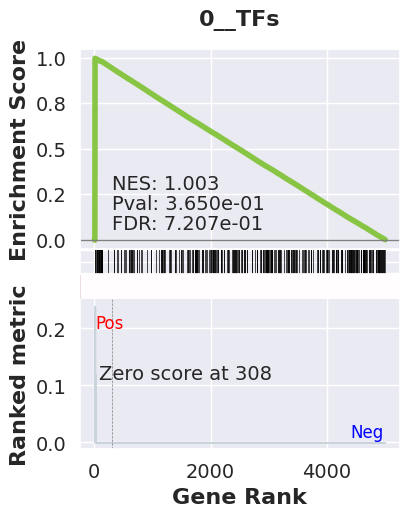

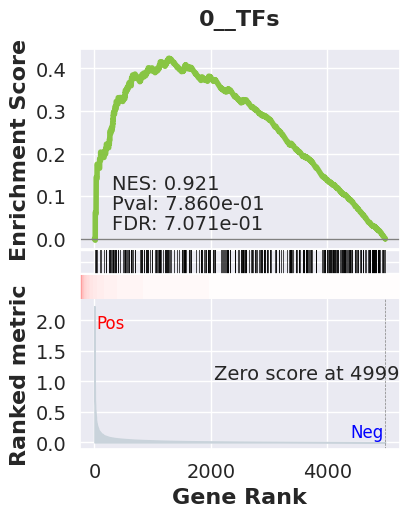

_________________________________________
TF specific enrichment


found some significant results for  6.382978723404255 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3603 genes
intersection pct: 0.7206
precision:  0.008450675315078615 
recall:  0.4179059026544181 
random precision: 0.001518183918238287



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 46.73it/s]


  9%|█████▌                                                           | 11/128 [00:00<00:02, 48.95it/s]


 12%|████████▏                                                        | 16/128 [00:00<00:02, 45.54it/s]


 17%|███████████▏                                                     | 22/128 [00:00<00:02, 47.47it/s]


 21%|█████████████▋                                                   | 27/128 [00:00<00:02, 45.34it/s]


 25%|████████████████▎                                                | 32/128 [00:00<00:02, 46.73it/s]


 29%|██████████████████▊                                              | 37/128 [00:00<00:01, 45.84it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 44.71it/s]


 37%|███████████████████████▊                                         | 47/128 [00:01<00:01, 43.14it/s]


 41%|██████████████████████████▍                                      | 52/128 [00:01<00:01, 44.33it/s]


 45%|████████████████████████████▉                                    | 57/128 [00:01<00:01, 44.41it/s]


 48%|███████████████████████████████▍                                 | 62/128 [00:01<00:01, 43.72it/s]


 52%|██████████████████████████████████                               | 67/128 [00:01<00:01, 44.87it/s]


 56%|████████████████████████████████████▌                            | 72/128 [00:01<00:01, 43.54it/s]


 60%|███████████████████████████████████████                          | 77/128 [00:01<00:01, 45.30it/s]


 64%|█████████████████████████████████████████▋                       | 82/128 [00:01<00:01, 44.39it/s]


 68%|████████████████████████████████████████████▏                    | 87/128 [00:01<00:00, 44.96it/s]


 72%|██████████████████████████████████████████████▋                  | 92/128 [00:02<00:00, 44.57it/s]


 76%|█████████████████████████████████████████████████▎               | 97/128 [00:02<00:00, 45.99it/s]


 80%|███████████████████████████████████████████████████             | 102/128 [00:02<00:00, 46.71it/s]


 84%|█████████████████████████████████████████████████████▌          | 107/128 [00:02<00:00, 44.81it/s]


 88%|████████████████████████████████████████████████████████        | 112/128 [00:02<00:00, 46.16it/s]


 91%|██████████████████████████████████████████████████████████▌     | 117/128 [00:02<00:00, 44.63it/s]


 95%|█████████████████████████████████████████████████████████████   | 122/128 [00:02<00:00, 45.87it/s]


 99%|███████████████████████████████████████████████████████████████▌| 127/128 [00:02<00:00, 44.56it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 45.04it/s]

Average Precision (AP):  0.005758509814252217
Area Under Precision-Recall Curve (AUPRC):  0.005066934469077497
EPR: 8.828760944706213


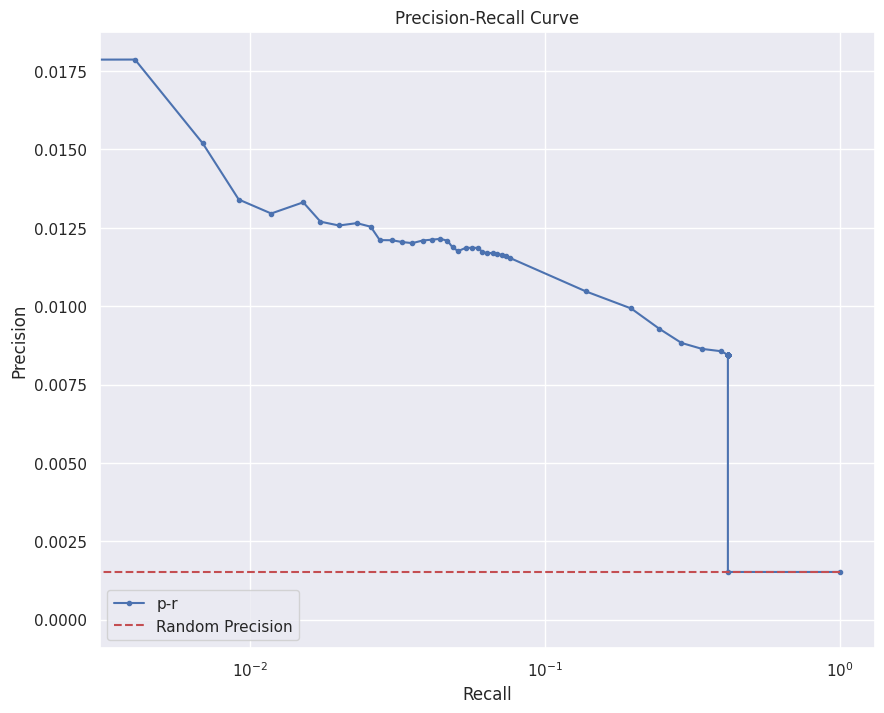

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/11 [00:00<?, ?it/s]

macrophage (41, 5000)
base enrichment


Top central genes: []


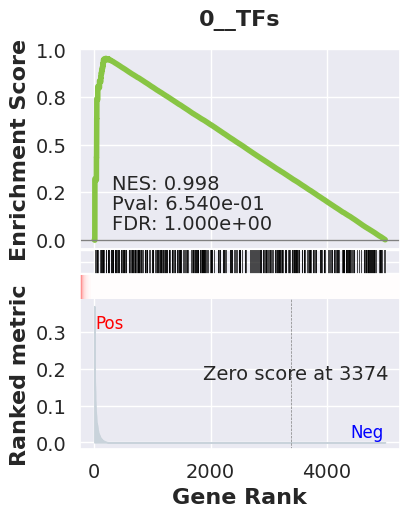

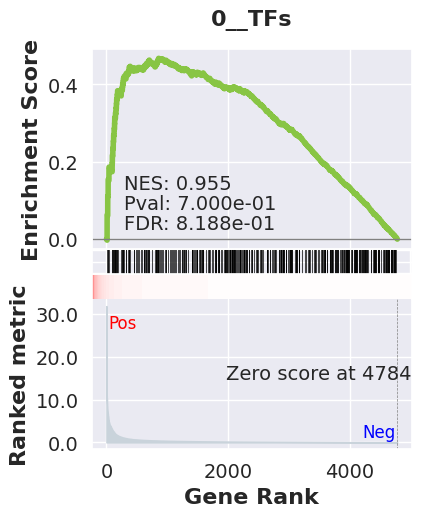

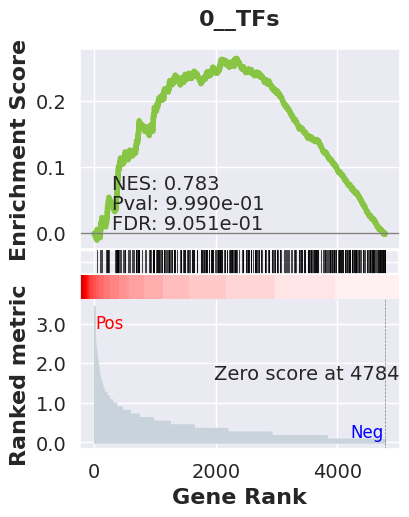

_________________________________________
TF specific enrichment


found some significant results for  24.390243902439025 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3553 genes
intersection pct: 0.7106
precision:  0.0016788950937943192 
recall:  0.4372986444593034 
random precision: 0.0013035393259851465



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 46.00it/s]


  9%|█████▌                                                           | 11/128 [00:00<00:02, 48.98it/s]


 12%|████████▏                                                        | 16/128 [00:00<00:02, 48.77it/s]


 16%|██████████▋                                                      | 21/128 [00:00<00:02, 47.46it/s]


 20%|█████████████▏                                                   | 26/128 [00:00<00:02, 46.33it/s]


 24%|███████████████▋                                                 | 31/128 [00:00<00:02, 47.34it/s]


 29%|██████████████████▊                                              | 37/128 [00:00<00:01, 48.58it/s]


 33%|█████████████████████▎                                           | 42/128 [00:00<00:01, 46.72it/s]


 38%|████████████████████████▍                                        | 48/128 [00:01<00:01, 48.33it/s]


 41%|██████████████████████████▉                                      | 53/128 [00:01<00:01, 46.99it/s]


 46%|█████████████████████████████▉                                   | 59/128 [00:01<00:01, 48.22it/s]


 50%|████████████████████████████████▌                                | 64/128 [00:01<00:01, 48.45it/s]


 54%|███████████████████████████████████                              | 69/128 [00:01<00:01, 48.66it/s]


 58%|█████████████████████████████████████▌                           | 74/128 [00:01<00:01, 47.44it/s]


 62%|████████████████████████████████████████▋                        | 80/128 [00:01<00:00, 48.86it/s]


 67%|███████████████████████████████████████████▋                     | 86/128 [00:01<00:00, 50.72it/s]


 72%|██████████████████████████████████████████████▋                  | 92/128 [00:01<00:00, 49.03it/s]


 77%|█████████████████████████████████████████████████▊               | 98/128 [00:02<00:00, 50.59it/s]


 81%|████████████████████████████████████████████████████            | 104/128 [00:02<00:00, 48.25it/s]


 85%|██████████████████████████████████████████████████████▌         | 109/128 [00:02<00:00, 48.67it/s]


 89%|█████████████████████████████████████████████████████████       | 114/128 [00:02<00:00, 47.34it/s]


 93%|███████████████████████████████████████████████████████████▌    | 119/128 [00:02<00:00, 47.71it/s]


 97%|██████████████████████████████████████████████████████████████  | 124/128 [00:02<00:00, 46.89it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 48.14it/s]

Average Precision (AP):  0.001683384241465711
Area Under Precision-Recall Curve (AUPRC):  0.0015962007163218663
EPR: 2.010449139192189


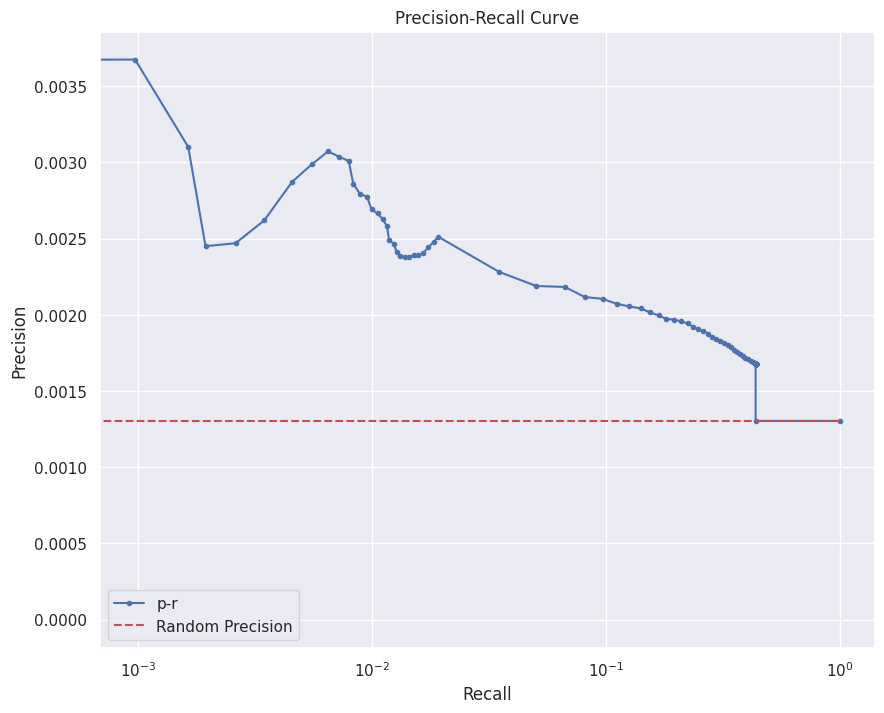

base enrichment


Top central genes: []


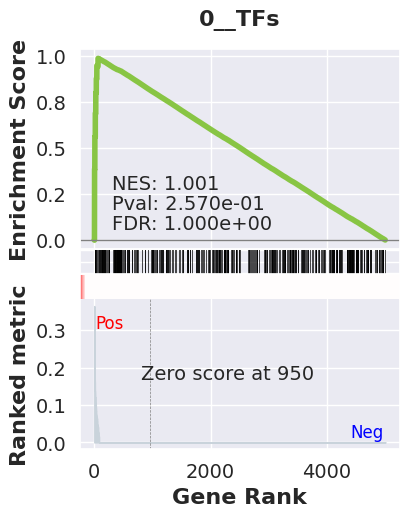

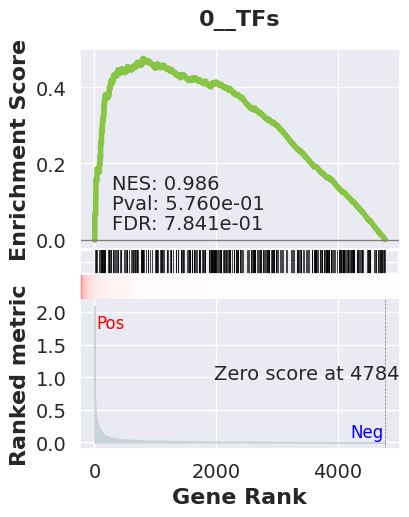

_________________________________________
TF specific enrichment


found some significant results for  9.75609756097561 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3553 genes
intersection pct: 0.7106
precision:  0.00963427454894923 
recall:  0.2205944927360039 
random precision: 0.0013035393259851465



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  4%|██▌                                                               | 5/128 [00:00<00:02, 46.26it/s]


  8%|█████                                                            | 10/128 [00:00<00:02, 44.21it/s]


 12%|███████▌                                                         | 15/128 [00:00<00:02, 45.87it/s]


 16%|██████████▏                                                      | 20/128 [00:00<00:02, 44.25it/s]


 20%|████████████▋                                                    | 25/128 [00:00<00:02, 44.70it/s]


 23%|███████████████▏                                                 | 30/128 [00:00<00:02, 44.32it/s]


 27%|█████████████████▊                                               | 35/128 [00:00<00:02, 45.53it/s]


 31%|████████████████████▎                                            | 40/128 [00:00<00:01, 44.43it/s]


 35%|██████████████████████▊                                          | 45/128 [00:01<00:01, 45.03it/s]


 39%|█████████████████████████▍                                       | 50/128 [00:01<00:01, 45.18it/s]


 43%|███████████████████████████▉                                     | 55/128 [00:01<00:01, 44.57it/s]


 48%|██████████████████████████████▉                                  | 61/128 [00:01<00:01, 45.99it/s]


 52%|█████████████████████████████████▌                               | 66/128 [00:01<00:01, 45.42it/s]


 55%|████████████████████████████████████                             | 71/128 [00:01<00:01, 46.09it/s]


 59%|██████████████████████████████████████▌                          | 76/128 [00:01<00:01, 46.86it/s]


 64%|█████████████████████████████████████████▋                       | 82/128 [00:01<00:00, 48.62it/s]


 68%|████████████████████████████████████████████▏                    | 87/128 [00:01<00:00, 47.59it/s]


 73%|███████████████████████████████████████████████▏                 | 93/128 [00:02<00:00, 48.79it/s]


 77%|█████████████████████████████████████████████████▊               | 98/128 [00:02<00:00, 49.00it/s]


 80%|███████████████████████████████████████████████████▌            | 103/128 [00:02<00:00, 47.57it/s]


 85%|██████████████████████████████████████████████████████▌         | 109/128 [00:02<00:00, 48.98it/s]


 89%|█████████████████████████████████████████████████████████       | 114/128 [00:02<00:00, 48.51it/s]


 93%|███████████████████████████████████████████████████████████▌    | 119/128 [00:02<00:00, 48.85it/s]


 97%|██████████████████████████████████████████████████████████████  | 124/128 [00:02<00:00, 48.34it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 46.90it/s]

Average Precision (AP):  0.004645521927091539
Area Under Precision-Recall Curve (AUPRC):  0.0038976348880987955
EPR: 14.426578352450875


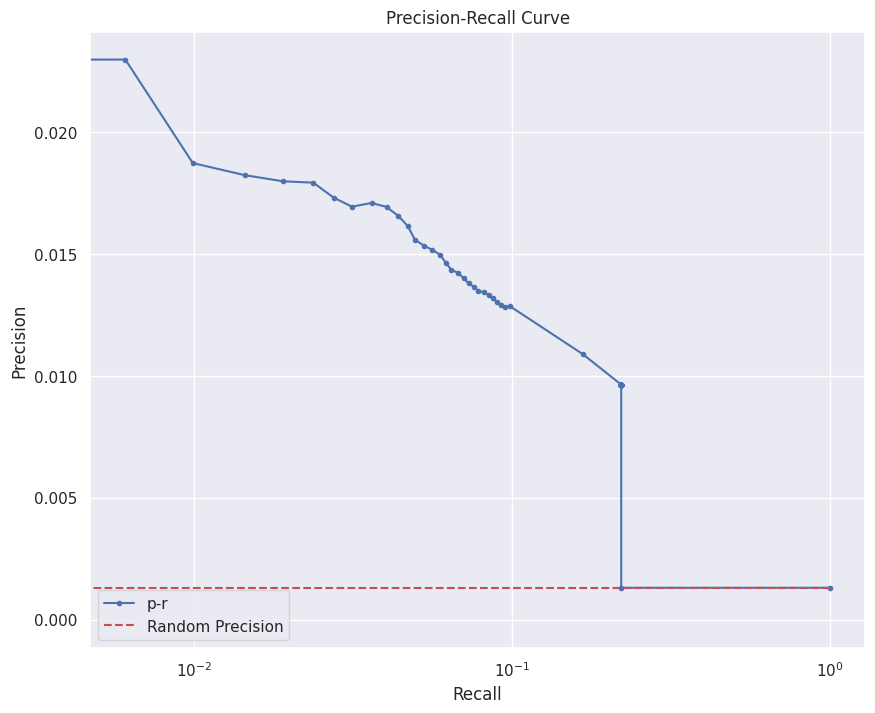

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/49 [00:00<?, ?it/s]

leukocyte (193, 4438)
base enrichment


Top central genes: []


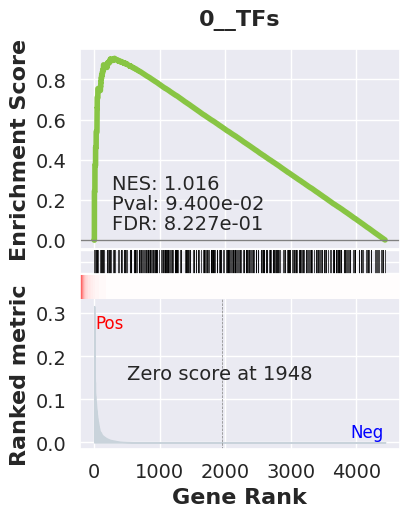

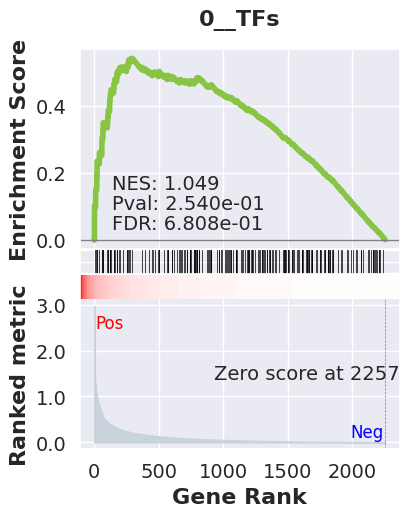

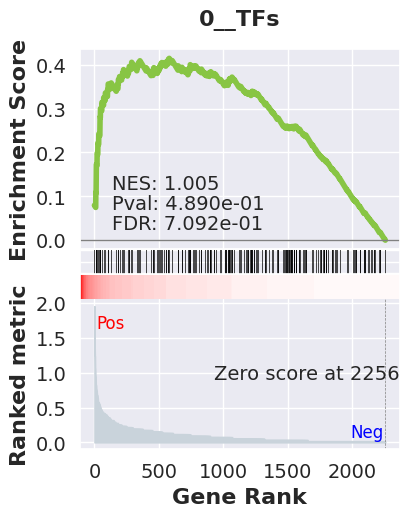

_________________________________________
TF specific enrichment


found some significant results for  4.761904761904762 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2564 genes
intersection pct: 0.5777377196935557
precision:  0.0024096988502008082 
recall:  0.13741438356164384 
random precision: 0.0010664179981167254



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  9%|█████▌                                                          | 11/128 [00:00<00:01, 102.75it/s]


 17%|███████████▏                                                     | 22/128 [00:00<00:01, 94.90it/s]


 26%|████████████████▊                                                | 33/128 [00:00<00:00, 98.36it/s]


 34%|█████████████████████▊                                           | 43/128 [00:00<00:00, 96.62it/s]


 43%|███████████████████████████▌                                    | 55/128 [00:00<00:00, 101.60it/s]


 52%|█████████████████████████████████                               | 66/128 [00:00<00:00, 102.02it/s]


 60%|███████████████████████████████████████                          | 77/128 [00:00<00:00, 98.48it/s]


 69%|████████████████████████████████████████████                    | 88/128 [00:00<00:00, 100.95it/s]


 77%|██████████████████████████████████████████████████▎              | 99/128 [00:01<00:00, 97.75it/s]


 86%|██████████████████████████████████████████████████████▏        | 110/128 [00:01<00:00, 101.08it/s]


 95%|████████████████████████████████████████████████████████████▌   | 121/128 [00:01<00:00, 99.10it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 99.32it/s]

Average Precision (AP):  0.0019131709382126786
Area Under Precision-Recall Curve (AUPRC):  0.0013457924010048426
EPR: 4.448023370717231


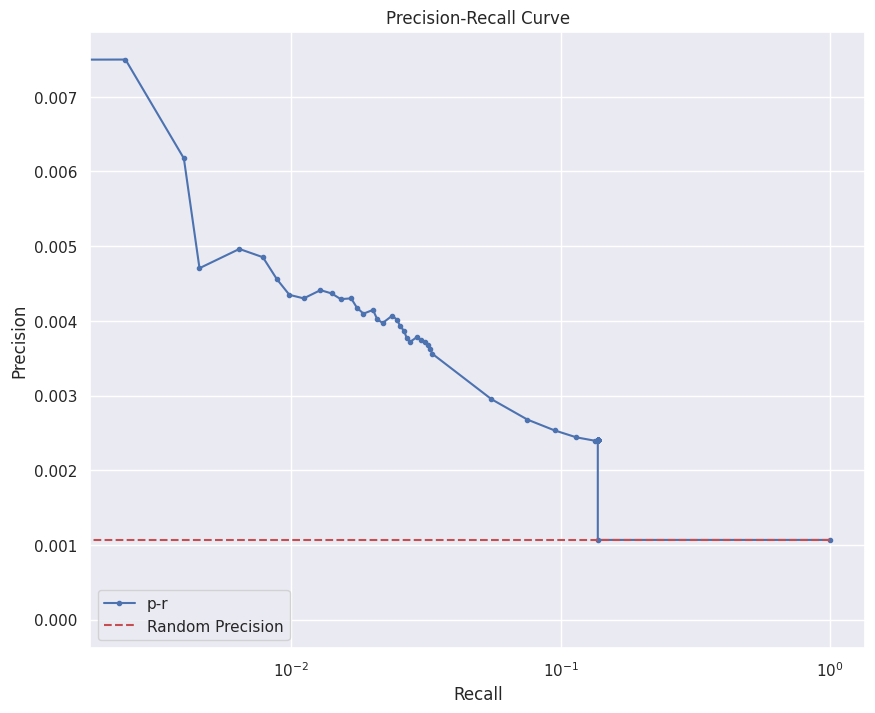

base enrichment


Top central genes: []


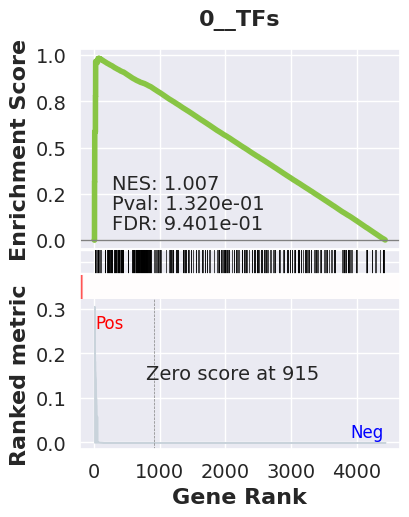

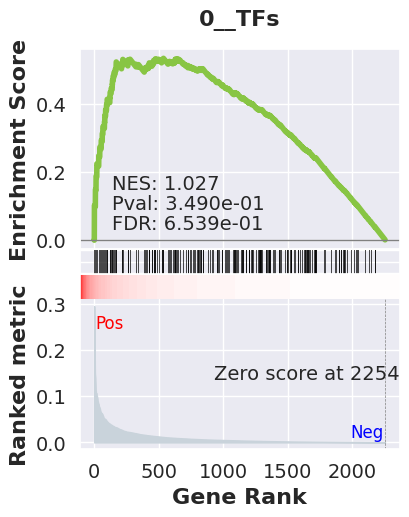

_________________________________________
TF specific enrichment


found some significant results for  4.761904761904762 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2564 genes
intersection pct: 0.5777377196935557
precision:  0.013892947867724749 
recall:  0.08818493150684932 
random precision: 0.0010664179981167254



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  7%|████▋                                                             | 9/128 [00:00<00:01, 87.26it/s]


 16%|██████████▏                                                      | 20/128 [00:00<00:01, 96.30it/s]


 24%|███████████████▋                                                 | 31/128 [00:00<00:00, 99.28it/s]


 32%|████████████████████▊                                            | 41/128 [00:00<00:00, 96.69it/s]


 41%|██████████████████████████                                      | 52/128 [00:00<00:00, 100.69it/s]


 49%|███████████████████████████████▉                                 | 63/128 [00:00<00:00, 97.61it/s]


 58%|█████████████████████████████████████▌                           | 74/128 [00:00<00:00, 99.52it/s]


 66%|██████████████████████████████████████████▋                      | 84/128 [00:00<00:00, 98.43it/s]


 73%|███████████████████████████████████████████████▋                 | 94/128 [00:00<00:00, 97.58it/s]


 81%|████████████████████████████████████████████████████            | 104/128 [00:01<00:00, 93.08it/s]


 90%|█████████████████████████████████████████████████████████▌      | 115/128 [00:01<00:00, 96.98it/s]


 99%|██████████████████████████████████████████████████████████████▌| 127/128 [00:01<00:00, 101.05it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 98.11it/s]

Average Precision (AP):  0.004302282196060121
Area Under Precision-Recall Curve (AUPRC):  0.0024723222936762963
EPR: 21.643119569452168


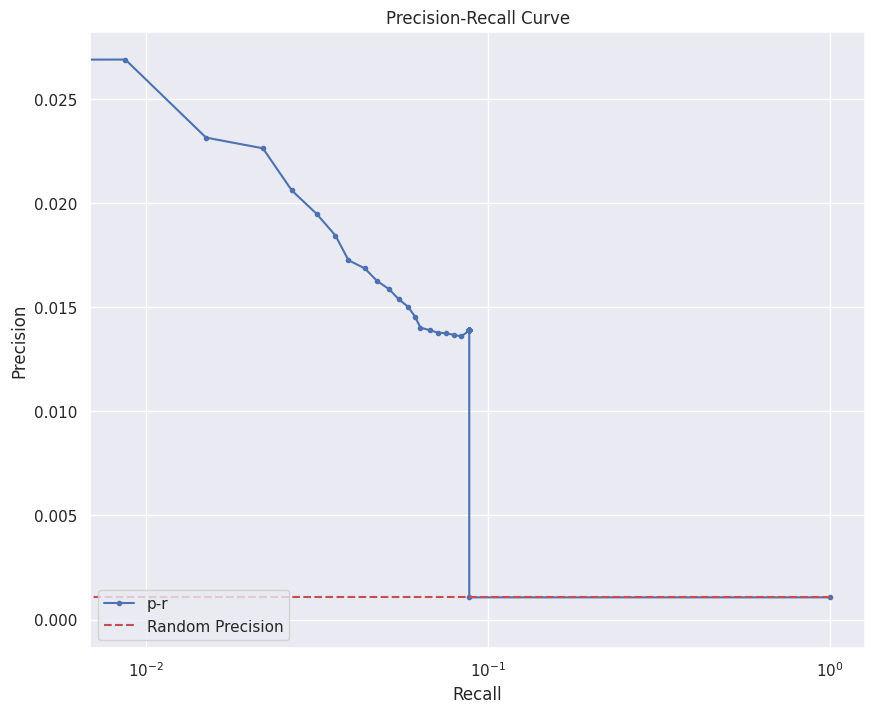

/tmp/ipykernel_2366157/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/43 [00:00<?, ?it/s]

kidney interstitial fibroblast (170, 5000)
base enrichment


Top central genes: []


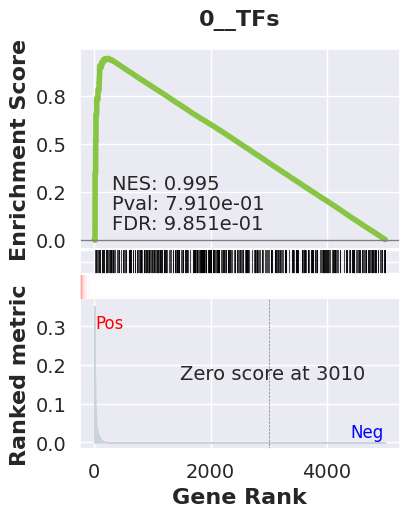

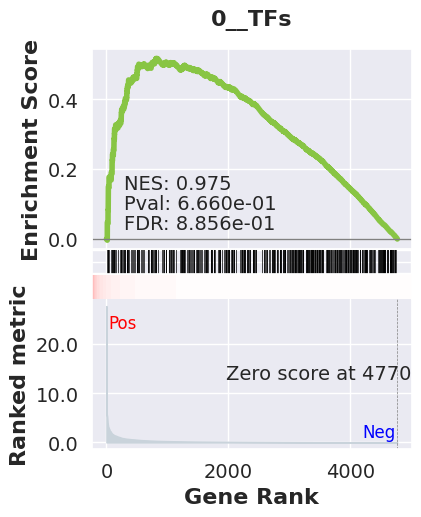

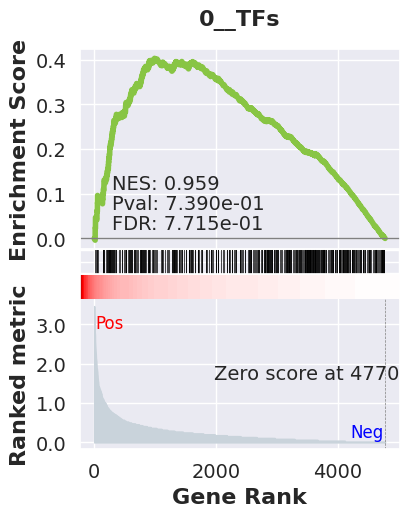

_________________________________________
TF specific enrichment


found some significant results for  18.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3540 genes
intersection pct: 0.708
precision:  0.0019605122547024945 
recall:  0.4688895979578813 
random precision: 0.0015009506659450864



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  5%|███                                                               | 6/128 [00:00<00:02, 53.24it/s]


  9%|██████                                                           | 12/128 [00:00<00:02, 50.12it/s]


 14%|█████████▏                                                       | 18/128 [00:00<00:02, 49.75it/s]


 19%|████████████▏                                                    | 24/128 [00:00<00:02, 49.94it/s]


 23%|██████████████▋                                                  | 29/128 [00:00<00:02, 47.03it/s]


 27%|█████████████████▊                                               | 35/128 [00:00<00:01, 48.56it/s]


 31%|████████████████████▎                                            | 40/128 [00:00<00:01, 48.87it/s]


 35%|██████████████████████▊                                          | 45/128 [00:00<00:01, 48.98it/s]


 40%|█████████████████████████▉                                       | 51/128 [00:01<00:01, 49.68it/s]


 44%|████████████████████████████▍                                    | 56/128 [00:01<00:01, 48.02it/s]


 48%|███████████████████████████████▍                                 | 62/128 [00:01<00:01, 48.98it/s]


 53%|██████████████████████████████████▌                              | 68/128 [00:01<00:01, 50.06it/s]


 58%|█████████████████████████████████████▌                           | 74/128 [00:01<00:01, 48.32it/s]


 62%|████████████████████████████████████████                         | 79/128 [00:01<00:01, 47.35it/s]


 66%|███████████████████████████████████████████▏                     | 85/128 [00:01<00:00, 49.02it/s]


 70%|█████████████████████████████████████████████▋                   | 90/128 [00:01<00:00, 48.23it/s]


 74%|████████████████████████████████████████████████▏                | 95/128 [00:01<00:00, 47.83it/s]


 79%|██████████████████████████████████████████████████▌             | 101/128 [00:02<00:00, 48.97it/s]


 83%|█████████████████████████████████████████████████████           | 106/128 [00:02<00:00, 47.84it/s]


 87%|███████████████████████████████████████████████████████▌        | 111/128 [00:02<00:00, 48.12it/s]


 91%|██████████████████████████████████████████████████████████▌     | 117/128 [00:02<00:00, 49.43it/s]


 95%|█████████████████████████████████████████████████████████████   | 122/128 [00:02<00:00, 47.86it/s]


 99%|███████████████████████████████████████████████████████████████▌| 127/128 [00:02<00:00, 46.67it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 48.41it/s]

Average Precision (AP):  0.0022249717945841616
Area Under Precision-Recall Curve (AUPRC):  0.0021394688052370904
EPR: 4.040131047098397


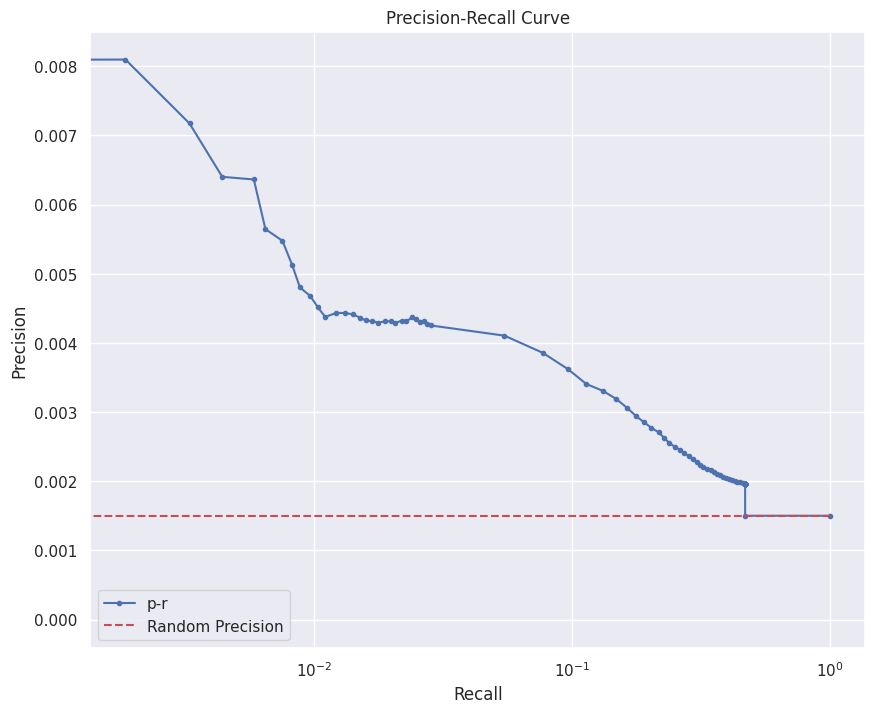

base enrichment


Top central genes: []


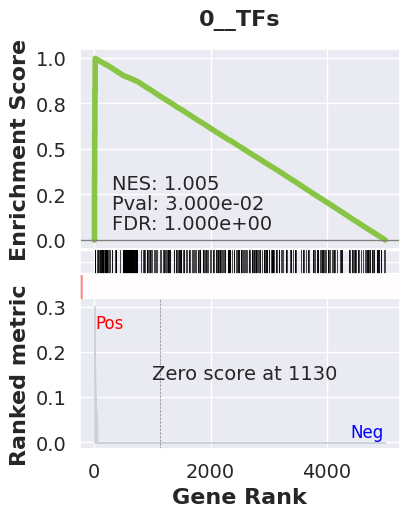

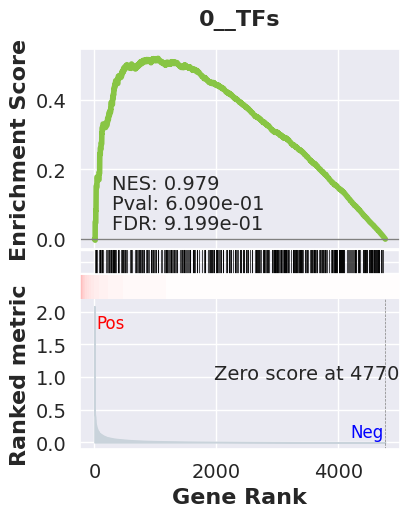

_________________________________________
TF specific enrichment


found some significant results for  12.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3540 genes
intersection pct: 0.708
precision:  0.010596324070529059 
recall:  0.2457987662199532 
random precision: 0.0015009506659450864



  0%|                                                                          | 0/128 [00:00<?, ?it/s]


  5%|███                                                               | 6/128 [00:00<00:02, 50.02it/s]


  9%|██████                                                           | 12/128 [00:00<00:02, 45.94it/s]


 14%|█████████▏                                                       | 18/128 [00:00<00:02, 47.86it/s]


 18%|███████████▋                                                     | 23/128 [00:00<00:02, 45.94it/s]


 23%|██████████████▋                                                  | 29/128 [00:00<00:02, 47.74it/s]


 27%|█████████████████▊                                               | 35/128 [00:00<00:01, 49.63it/s]


 31%|████████████████████▎                                            | 40/128 [00:00<00:01, 49.60it/s]


 35%|██████████████████████▊                                          | 45/128 [00:00<00:01, 48.52it/s]


 40%|█████████████████████████▉                                       | 51/128 [00:01<00:01, 50.19it/s]


 45%|████████████████████████████▉                                    | 57/128 [00:01<00:01, 47.54it/s]


 49%|███████████████████████████████▉                                 | 63/128 [00:01<00:01, 49.22it/s]


 53%|██████████████████████████████████▌                              | 68/128 [00:01<00:01, 47.34it/s]


 57%|█████████████████████████████████████                            | 73/128 [00:01<00:01, 46.58it/s]


 61%|███████████████████████████████████████▌                         | 78/128 [00:01<00:01, 46.24it/s]


 66%|██████████████████████████████████████████▋                      | 84/128 [00:01<00:00, 48.58it/s]


 70%|█████████████████████████████████████████████▏                   | 89/128 [00:01<00:00, 47.74it/s]


 73%|███████████████████████████████████████████████▋                 | 94/128 [00:01<00:00, 46.89it/s]


 78%|██████████████████████████████████████████████████              | 100/128 [00:02<00:00, 48.75it/s]


 82%|████████████████████████████████████████████████████▌           | 105/128 [00:02<00:00, 46.06it/s]


 87%|███████████████████████████████████████████████████████▌        | 111/128 [00:02<00:00, 47.84it/s]


 91%|██████████████████████████████████████████████████████████      | 116/128 [00:02<00:00, 47.08it/s]


 95%|████████████████████████████████████████████████████████████▌   | 121/128 [00:02<00:00, 45.16it/s]


 98%|███████████████████████████████████████████████████████████████ | 126/128 [00:02<00:00, 46.21it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 47.50it/s]

Average Precision (AP):  0.0068873423436844414
Area Under Precision-Recall Curve (AUPRC):  0.005373120353770225
EPR: 19.587331708554984


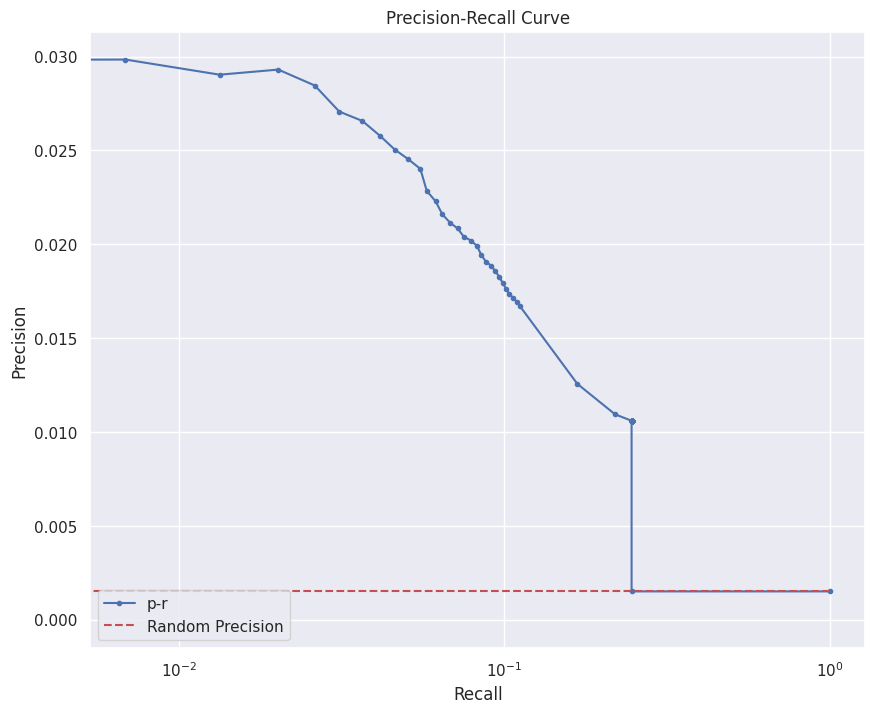

In [7]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
adata = adata[adata.X.sum(1) > 500]
shapes = []
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:MAXCELLS,  adata.var.index.isin(to_use)]
    grn = compute_geneformer_network(
        subadata)
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    print(celltype, grn.shape)
    metrics['geneformer_'+celltype] = BenGRN(grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    grn.varp['GRN'][~grn.var.isTF, :] = 0
    metrics['geneformer_tf'+celltype] = BenGRN(grn,
                                         do_auc=True, doplot=True).scprint_benchmark()
    shapes.append(grn.shape[1])

In [8]:
shapes

[5000, 5000, 5000, 4802, 5000, 5000, 5000, 4438, 5000]

In [9]:
metrics

{'geneformer_kidney distal convoluted tubule epithelial cell': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Distal tubule cells'],
  'enriched_terms_Targets': ['celltype.gmt__Distal tubule cells',
   'celltype.gmt__-intercalated cells (Collecting duct system)',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Connecting tubule cells',
   'celltype.gmt__Ductal cells',
   'celltype.gmt__Proximal tubule cells',
   'celltype.gmt__Enterocytes',
   'celltype.gmt__Hepatocytes',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Principal cells (Collecting duct system)'],
  'significant_enriched_TFtargets': 17.647058823529413,
  'precision': 0.0010623619711281117,
  'recall': 0.9992590397154713,
  'rand_precision': 0.001062203773751226,
  'auprc': 0.0012203552961740885,
  'ap': 0.0012211835133077254,
  'epr': 1.3262989466872428},
 'geneformer_tfkidney distal convoluted tubule epithelial cell

In [10]:
False
True
True
True
True
True
True
False
True
True
True
True
False
False
False
False
True
True


True

In [11]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,kidney distal convoluted tubule epithelial cell,1.326299,0.001220,0.001062,17.647059,False,False
1,tfkidney distal convoluted tubule epithelial cell,8.287360,0.002846,0.001062,11.764706,False,False
2,kidney loop of Henle thick ascending limb epit...,1.047723,0.001327,0.001212,7.500000,False,False
3,tfkidney loop of Henle thick ascending limb ep...,8.418531,0.003861,0.001212,2.500000,False,False
4,kidney collecting duct principal cell,2.135805,0.001753,0.001362,15.714286,False,False
5,tfkidney collecting duct principal cell,11.772423,0.005743,0.001362,5.714286,False,False
6,mesangial cell,2.204137,0.001386,0.001064,9.090909,False,False
7,tfmesangial cell,19.364686,0.003521,0.001064,2.272727,False,False
8,blood vessel smooth muscle cell,2.793994,0.002276,0.001672,26.785714,False,False
9,tfblood vessel smooth muscle cell,13.644959,0.005692,0.001672,8.928571,False,False
